# Multi-aspect recommendation

Let $X = (x_1, x_2, \ldots, x_N)$ be a set of points for which we would like to build a recommendation system.

Let $\mathcal{S} = (S_1, \dots, S_l)$ be a collection of similarity indices with $S_i(x_p, x_q)$ being the similarity score of $x_p, x_q \in X$ according to the index $S_i$. If $S_i(x_p, x_q) > S_i(x_p, x_r)$, we say that, according to $S_i$, $x_q$ is more similar to $x_p$ than $x_r$.

__Example__: For neuron morphologies, we can have the following similarity indices: $\mathcal{S} = (S_{xyz}, S_{neurites}, S_{axons}, S_{dendrites})$, where for a pair of morphologies:

- $S_{xyz}$ gives a similarity score according to their 3D coordinates in the brain;
- $S_{neurites}$ gives a similarity score according to neurite feature space;
- $S_{axons}$ gives a similarity score according to their location in the axon co-projection graph;
- $S_{dendrites}$ gives a similarity score according to their location in the dendrite co-projection graph.

The single-aspect recommendation task can be defined as follows. Given some __query__ $x \in X$ and some index $S_i$, which we will call __aspect__, find $K$ most similar points to $x$ (which correspond to $K$ points with the highest value $S_i(x)$).

The multi-aspect recommendation task can be defined as follows. Given some __query__ $x \in X$ and some __set of aspects__ $\mathcal{S} = (S_1, \ldots, S_l)$, find $K$ most similar points to $x$ according to some aggregated similarity index $\hat{S}[S_1, \ldots, S_l]$ (which correspond to $K$ points with the highest aggregated similarity score).


## 1. Converting distances to similarities

Let $\mathcal{D} = (D_1, \dots, D_k)$ be a collection of indices buit using some __distance__ measure, where $D_i(x_p, x_q)$ is the distance value between $x_p$ and $x_q$ according to the index $D_i$. If $D_i(x_p, x_q) < D_i(x_p, x_r)$, we say that, according to $D_i$, $x_q$ is closer to $x_p$ in comparison to $x_r$.

We can convert a distance measure $D_i(x_p, x_q)$ to similarity by applying the following formula:

$$S_i(x_p, x_q) = \frac{1}{1 + D_i(x_p, x_q)}$$

__Optional__: Since the values of $D_i$ can vary greatly, we may need to normalize them to get a more stable similarity score $S_i$ (which tends to diminish quickly with increasing $D_i$). Two things can be performed in order to normalize the distance values:

1. Scaling of the original space (dividing all coordinates by some fixed factor, for example, mean/max value from all the coordinates);
2. Min-max of our distance values.

## 2. Normalizing similarity scores

### 2.1. Min-max scaling

To make sure that the range of similarity values lies in $[0, 1]$, we can apply __min-max scaling__, i.e. we can compute

$$\bar{S}_i(x_p, x_q) = \frac{S_i(x_p, x_q) - min_{x_s, x_t \in X \times X}S_i(x_s, x_t)}{max_{x_s, x_t \in X \times X}S_i(x_s, x_t) - min_{x_s, x_t \in X \times X}S_i(x_s, x_t)}$$

for $x_p, x_q \in X$.

### 2.2. Local density boosting

Additional normalization of our similarity scores that increases their comparability can be done by boosting individual similarity scores for points with low local density. Here is a little motivation for such normalization from [this article](
https://towardsdatascience.com/a-practitioners-guide-to-similarity-scoring-part-1-29625b9ac481):


_"The perceived similarity of the locations of two objects usually depends on the context surrounding those objects. In our credit card transactions example, two transactions that happen one mile apart in Siberia are more likely to be related than transactions one mile apart in Manhattan."_

__Example__: Let $m$ be a morphology and $S_{xyz}$, $S_{neurites}$ be two similarity indices computed from the space representing 3D coordinates of morphologies and the space of their neurite features respectively. Let $m$ be a point with a low local density in the space of 3D coordinates, i.e. all its neighboring morphologies are located at a large distance and, therefore, have a relatively low similarity score. On the other hand, let $m$ be a point with a high local density in the space of neurite features, i.e. all its neighboring morphologies are located at a small distance and, therefore, have a relatively high similarity score. When averaging scores for neighbors of $m$ in these two spaces, the similarity score in the space of neurite features will always dominate and produce an unbalanced aggregated score that biases towards the morphologies with closer neurite features.

To account for uneven distribution of points in the original spaces (representing our similarity aspects) we can perform the following boosting procedures for distances.

Let us denote with $N_i$ the set of $K$ nearest neighbors of $x$ according to $S_i$. We can calculate a _boosting factor_ for $x$ according to $S_i$ as a root mean square deviation:

$$b_i(x) = \sqrt{ \frac{1}{K} \sum_{x_q \in N_i} (1 - S_i(x, x_q))^2 }$$

Using this boosting factor we can now boost our similarity scores as follows.

$$\tilde{S}^{x}_i(x_q) = (1 + b_i(x)) \times S_i(x, x_q)$$

Note that boosted similarity is not symmetric, i.e. the similarity $\tilde{S}^{x_p}_i(x_q)$ of $x_q$ to $x_p$ is not necessarily the same as the similarity $\tilde{S}^{x_q}_i(x_p)$ of $x_p$ to $x_q$.

This is not an issue for our recommendation system as we boost similarity scores for all the neighbors of a particular _query_ point using the boosting factor for that point. For example, let the boosting factor of $x$ for the similarity aspect $S_i$ be $b_i(x)$, then we find $N_i$ the set of $K$ nearest neighbors of $x$ according to $S_i$. We compute similaritites $S_i(x, x_j)$ for all $x_j \in N_i$ and we boost them by applying $(1 + b_i(x)) \times S_i(x, x_j)$. 


In order to make sure that the range of boosted similarity values lies in $[0, 1]$, we can apply the min-max scaling described above.


## 3. Aggregating similarity scores

Let $\hat{S}[S_1, \ldots, S_l]$ be an aggregated similarity index given a set of individual indices $\mathcal{S} = (S_1, \ldots, S_l)$. We will denote it with $\hat{S}$ for the sake of simplicity. We can compute this aggregated similarity score using the following operators.

### 3.1. Simple arithmetic average
$$\hat{S}(x_p, x_q) = \frac{1}{l} \sum_{i=1}^l S_i(x_p, x_q)$$

for $x_p, x_q \in X$.


### 3.2. Weighted arithmetic average

Given a sequence of weights $w_1, \ldots, w_l$ such that $\sum_{i=1}^l w_i = 1$, we can aggregate individual similarity scores using weighted average as follows:

$$\hat{S}(x_p, x_q) = \frac{1}{l} \sum_{i=1}^l w_i \times S_i(x_p, x_q)$$

for $x_p, x_q \in X$.

Boosting described in the previous section can be applied in a similar way 

### 3.3. Generalized average

Given a parameter $\lambda \neq 0$:

$$\hat{S}(x_p, x_q) = \left( \frac{1}{l} \sum_{i=1}^l S_i(x_p, x_q)^{\lambda} \right) ^{1/\lambda}$$

for $x_p, x_q \in X$.

# Experiments on combining embedding vectors

We would like to combine:

- Exact match queries (get morphologies from a brain region X)
- Multiple embedding vectors produced by models tackling similarity according to different aspects (vectors representing a morphology in a latent co-projection graph space, get 10 most similar morphologies in that space) --> focus of this notebook
- Ontology queries (get similar species, similar or adjacent brain region: get morphologies of this species/brain region)
- Full text search

For embeddings, we need to build rank aggregation functions.

"Rank aggregation functions allow retrieval models (or rankers) to be builton top of others.  They combine results from different rankers and promote more effective retrieval results, without dealing with raw data or low-level descriptors. Besides, even heterogeneous models such as text-based or image-based can begathered together.  Rank aggregation techniques are important in many appli-cations, such as meta-search, document filtering, recommendation systems, andsocial choice."

In [110]:
import ast
import math
import pickle
import re
import getpass
import requests
import faiss

from collections import defaultdict

import networkx as nx
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.neighbors import BallTree, DistanceMetric

from gensim.models.poincare import PoincareModel

import matplotlib.pyplot as plt

import seaborn as sns  # for pretty density plots

from bluegraph import PandasPGFrame
from bluegraph.backends.networkx import networkx_to_pgframe, NXPathFinder
from bluegraph.downstream import transform_to_2d, plot_2d

from kgforge.core import KnowledgeGraphForge

#  Prepare a sample data

In [111]:
data = pd.read_csv("../../data/combined_data.csv")

In [112]:
data.head(4)

,@id,coordinates,neurite_features,axon_coproj_embedding,dendrite_coproj_embedding,brain_region,atlas_release,object_of_study,generation.activity.hadProtocol.id
0,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7201.0, 3716.0, 3749.0]","[-0.10505343819575737, -0.08592934565688644, -...","[0.18896199762821198, -0.16705186665058136, 0....","[0.18793269991874695, 0.13808520138263702, 0.1...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
1,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7075.0, 3636.0, 3527.0]","[-1.081209029716594, -0.9150395167657966, -0.9...","[0.10726464539766312, -0.18415719270706177, 0....","[0.22176018357276917, 0.20632661879062653, 0.1...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
2,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7198.0, 3515.0, 3370.0]","[-0.8884510254524829, -0.48045230911256653, -0...","[0.16980499029159546, -0.1570582091808319, 0.1...","[0.14578984677791595, 0.1419796198606491, 0.22...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
3,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7297.0, 3313.0, 3460.0]","[-0.7066540810820133, -1.2028093636935826, -1....","[0.1365632265806198, -0.16423176229000092, 0.1...","[0.1507139950990677, 0.12866976857185364, 0.15...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...


In [113]:
with open("../../data/thalamus_partition_edges.pkl", "rb") as f:
    thalamus_partition = pickle.load(f)

# Mapping of Allen notations to uberon terms
allen_to_uberon = {
    "AM": "anteromedial nucleus of thalamus",
    'VPL': "ventral posterolateral nucleus",
    'SMT': "submedial nucleus of thalamus",
    'VAL': "ventral lateral nucleus of thalamus",
    'MG': "medial geniculate body",
    'PO': "posterior nuclear complex of thalamus",
    'CM': "central medial nucleus",
    'LP': "lateral posterior nucleus of thalamus",
    'VPMpc': "parvicellular part of ventral posteromedial nucleus",
    'VPM': "ventral posteromedial nucleus of thalamus",
    'RE': "reuniens nucleus",
    'MD': "medial dorsal nucleus of thalamus",
    'RT': "thalamic reticular nucleus",
    'VPLpc': "parvicellular part of ventral posteromedial nucleus",
    'LGd': "dorsal lateral geniculate nucleus",
    'IAD': "interanterodorsal nucleus of the thalamus",
    'PVT': "paraventricular nucleus of thalamus"
}

In [114]:
model = PoincareModel(thalamus_partition, size=32, negative=2)
model.train(epochs=100)

In [115]:
vectors = [
    model.kv.get_vector(allen_to_uberon[el])
    for el in data["brain_region"]
]
data["region_vector"] = vectors

In [116]:
KEYWORDS = [
    "@id", "@type",
    "brain_region",
    "atlas_release",
    "object_of_study",
]

In [117]:
EMBEDDING_VECTORS = {
    "coordinates": "euclidean",
    "neurite_features": "euclidean",
    "axon_coproj_embedding": "cosine",
    "dendrite_coproj_embedding": "cosine",
    "region_vector": "poincare"
}

In [119]:
for c in EMBEDDING_VECTORS:
    try:
        data[c] = data[c].apply(lambda x: ast.literal_eval(x))
    except ValueError:
        pass

Scale coordinates and neurite features

In [120]:
coordinates = np.array(data["coordinates"].tolist())
data["coordinates"] = (coordinates / coordinates.max()).tolist()

In [121]:
neurite_features = np.array(data["neurite_features"].tolist())
data["neurite_features"] = (neurite_features / neurite_features.max()).tolist()

In [122]:
releases = ["release1", "release2", "release3"]
data["atlas_release"] = pd.Series([
    np.random.choice(releases, p=[0.4, 0.4, 0.2])
    for n in data["@id"]
])
objects = ["Single Cell", "Whole Brain"]
data["object_of_study"] = pd.Series([
    np.random.choice(objects, p=[0.6, 0.4])
    for n in data["@id"]
])

In [123]:
morphologies = data[["@id", "brain_region", "atlas_release", "object_of_study"]]
morphologies["@type"] = "NeuronMorphology"

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Experiments with brain region similaritites based on ontologies

In [124]:
brain_region_frame = PandasPGFrame.load_json("../../data/brain_region_data.json")

In [125]:
finder = NXPathFinder(brain_region_frame, directed=False)

In [126]:
def brain_region_ontology_distance(finder, r1, r2):
    return int(math.log2(len(finder.shortest_path(r1, r2))))

In [127]:
brain_region_ontology_distance(finder, "VPL", "VPM")

1

In [128]:
brain_region_ontology_distance(finder, "VPL", "MG")

2

In [129]:
brain_region_ontology_distance(finder, "VPL", "LP")

3

# Experiments with rank aggregation

## Create Faiss indices

In [309]:
def poincare_distance(vector_1, vector_2):
    v1_norm = np.linalg.norm(vector_1)
    v2_norm = np.linalg.norm(vector_2)
    euclidean_distance = np.linalg.norm(vector_1 - vector_2)
    value = 1 + 2 * (
        (euclidean_distance ** 2) / ((1 - v1_norm ** 2) * (1 - v2_norm ** 2))
    )
    return np.arccosh(value)

In [310]:
def create_index(dim, vectors, similarity="cosine"):
    vectors = np.array(vectors).astype(np.float32)
    if similarity == "poincare":
        return BallTree(
            vectors, leaf_size=20,
            metric=DistanceMetric.get_metric('pyfunc', func=poincare_distance))
    if similarity == "cosine":
        index = faiss.IndexFlatIP(dim)
        faiss.normalize_L2(vectors)
    else:
        index = faiss.IndexFlatL2(dim)
    index.add(vectors)
    return index

In [311]:
def query_index(index, point_ids, k, similarity="euclidean"):
    if isinstance(index, BallTree):
        vectors, _, _, _ = index.get_arrays()
        return index.query(vectors[point_ids], k)
    else:
        vectors = np.array([
            index.reconstruct(point)
            for point in point_ids
        ])
        if similarity == "cosine":
            faiss.normalize_L2(vectors)
        return index.search(vectors, k)

In [312]:
def compute_distance(index, p1, p2):
    if isinstance(index, BallTree):
        vectors, _, _, _ = index.get_arrays()
        return poincare_distance(vectors[p1], vectors[p2])
    else:
        comp = index.get_distance_computer()
        return comp.symmetric_dis(p1, p2)

In [313]:
coordiates_index = create_index(3, data["coordinates"].tolist(), similarity="euclidean")

In [314]:
neurite_feature_index = create_index(
    len(data["neurite_features"].iloc[0]), data["neurite_features"].tolist(), similarity="euclidean")

In [315]:
axon_index = create_index(
    len(data["axon_coproj_embedding"].iloc[0]), data["axon_coproj_embedding"].tolist(), similarity="cosine")

In [316]:
dendrite_index = create_index(
    len(data["dendrite_coproj_embedding"].iloc[0]), data["dendrite_coproj_embedding"].tolist(), similarity="cosine")

In [317]:
poincare_index = create_index(
    len(data["region_vector"].iloc[0]), data["region_vector"].tolist(), similarity="poincare")

In [318]:
SIMILARITIES = {
    "coordindates": "euclidean",
    "neurite_features": "euclidean",
    "axon_coproj": "cosine",
    "dendrite_coproj": "cosine",
    "region_vector": "poincare"
}
INDICES = {
    "coordindates": coordiates_index,
    "neurite_features": neurite_feature_index,
    "axon_coproj": axon_index,
    "dendrite_coproj": dendrite_index,
    "region_vector": poincare_index
}
COLORS = {
    "coordindates": "green",
    "neurite_features": "orange",
    "axon_coproj": "red",
    "dendrite_coproj": "blue",
    "region_vector": "purple"
}

In [319]:
BENCHMARK_POINTS = [
    int(p)
    for p in np.random.choice(range(data.shape[0]), 50)
]
K = 20

In [320]:
individual_benchmarks = {}
for index_name, index in INDICES.items():
    _, points = query_index(index, BENCHMARK_POINTS, K)
    individual_benchmarks[index_name] = {
        BENCHMARK_POINTS[i]: pset
        for i, pset in enumerate(points)
    }

## Vecotor concatenation + PCA (Offline: building index)

In [321]:
all_features = np.hstack([
    np.vstack(data["coordinates"].values),
    np.vstack(data["neurite_features"].values),
    np.vstack(data["axon_coproj_embedding"].values),
    np.vstack(data["dendrite_coproj_embedding"].values),
    np.vstack(data["region_vector"].values)])
print(all_features.shape[1])

303


In [322]:
pca = sk.decomposition.PCA(n_components=128)
reduced_features = pca.fit_transform(all_features)
print(sum(pca.explained_variance_ratio_))
concatenated_index = create_index(
    reduced_features.shape[1], np.ascontiguousarray(reduced_features, dtype=np.float32))

0.9845532039400249


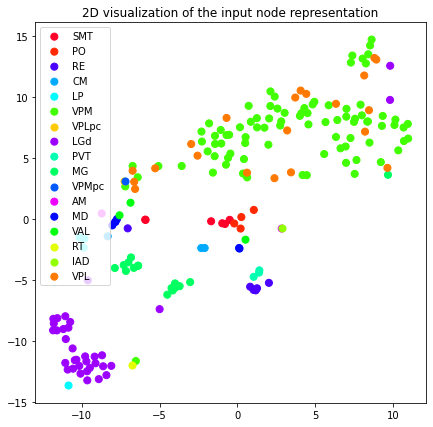

In [323]:
embedding_2d = transform_to_2d(all_features.tolist())
plot_2d(None, vectors=embedding_2d, labels=data["brain_region"])

In [324]:
_, points = query_index(concatenated_index, BENCHMARK_POINTS, K)

In [325]:
concatenated_benchmarks = {
    BENCHMARK_POINTS[i]: pset for i, pset in enumerate(points)
}

In [326]:
all_features_no_coord = np.hstack([
    np.vstack(data["neurite_features"].values),
    np.vstack(data["axon_coproj_embedding"].values),
    np.vstack(data["dendrite_coproj_embedding"].values)])
print(all_features_no_coord.shape[1])

268


In [327]:
pca = sk.decomposition.PCA(n_components=64)
reduced_features = pca.fit_transform(all_features_no_coord)
print(sum(pca.explained_variance_ratio_))
concatenated_index = create_index(
    reduced_features.shape[1], np.ascontiguousarray(reduced_features, dtype=np.float32))

0.9164705137742072


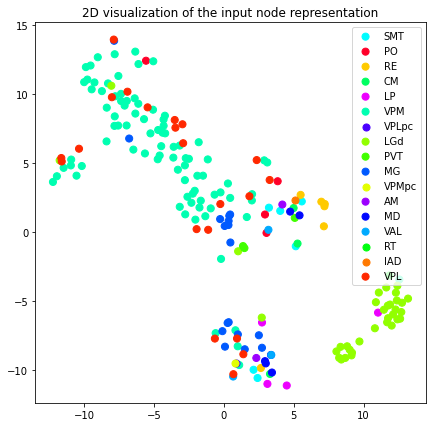

In [328]:
embedding_2d = transform_to_2d(all_features_no_coord.tolist())
plot_2d(None, vectors=embedding_2d, labels=data["brain_region"])

In [329]:
_, points = query_index(concatenated_index, BENCHMARK_POINTS, K)

In [330]:
concatenated_minus_benchmarks = {
    BENCHMARK_POINTS[i]: pset for i, pset in enumerate(points)
}

__Issues__:

- Some embeddings can have features with high variance, dominating over the other embeddings
- Combining things for which different similarity metrics should be employed does not make much sense

## Naive score aggregation

### Experiment with distance distributions

In [402]:
points = list(range(data.shape[0]))
similarities = defaultdict(list)
for index_name, index in INDICES.items():
    for p1 in points:
        for p2 in points:
            if p1 < p2:
                d = compute_distance(index, p1, p2)
                similarities[index_name].append(d)

coordindates
	range: [0.00, 0.19]
	mean: 0.03, std: 0.03


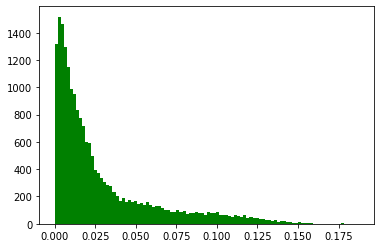

neurite_features
	range: [0.00, 2.37]
	mean: 0.38, std: 0.35


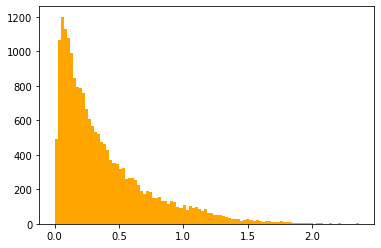

axon_coproj
	range: [0.79, 0.99]
	mean: 0.97, std: 0.03


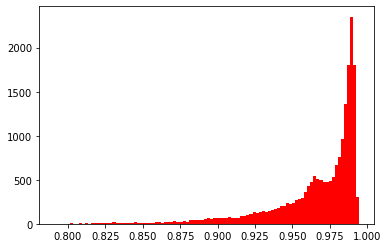

dendrite_coproj
	range: [0.96, 1.00]
	mean: 0.99, std: 0.00


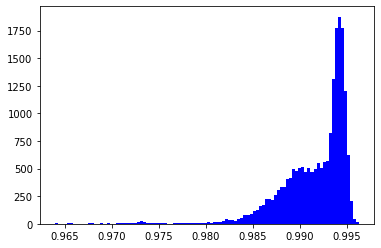

region_vector
	range: [0.00, 4.02]
	mean: 1.48, std: 1.00


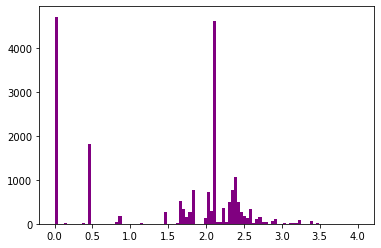

In [403]:
for k in similarities:
    values = np.array(similarities[k])
    print(k)
    print("\trange: [{:.2f}, {:.2f}]".format(min(values), max(values)))
    print("\tmean: {:.2f}, std: {:.2f}".format(values.mean(), values.std()))
    plt.hist(values, bins=100, color=COLORS[k])
    plt.show()

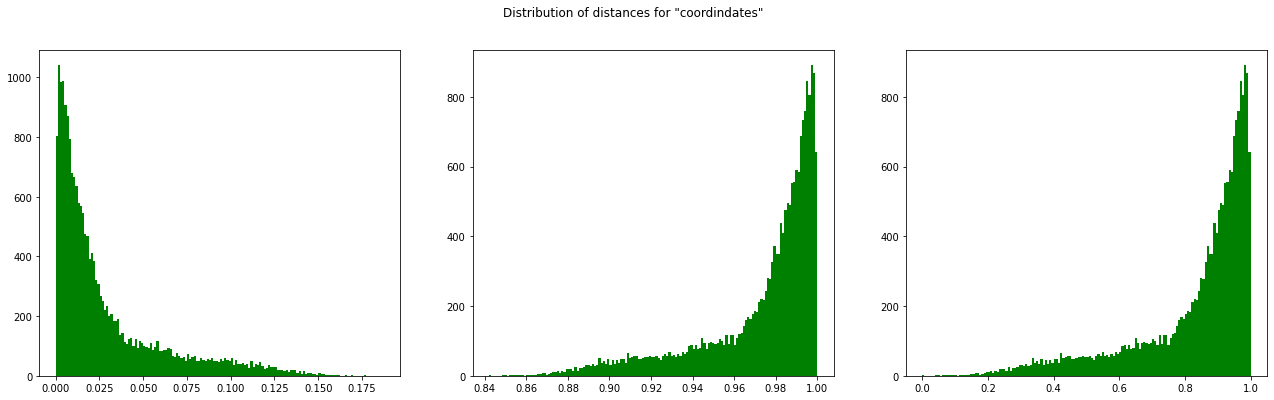

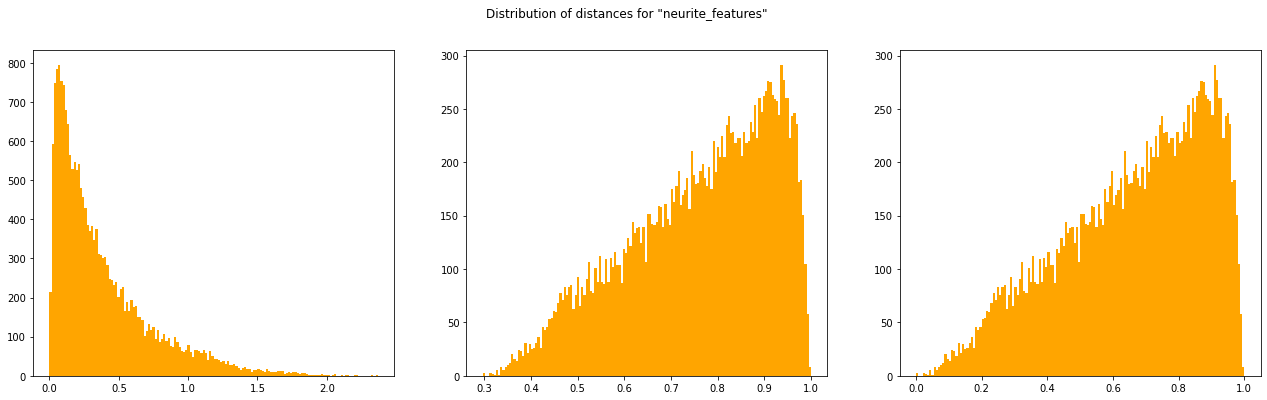

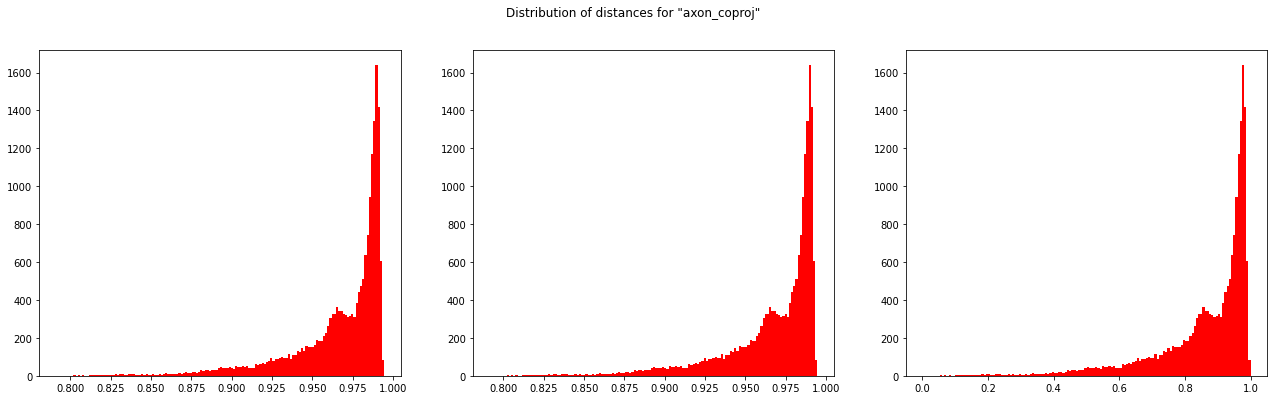

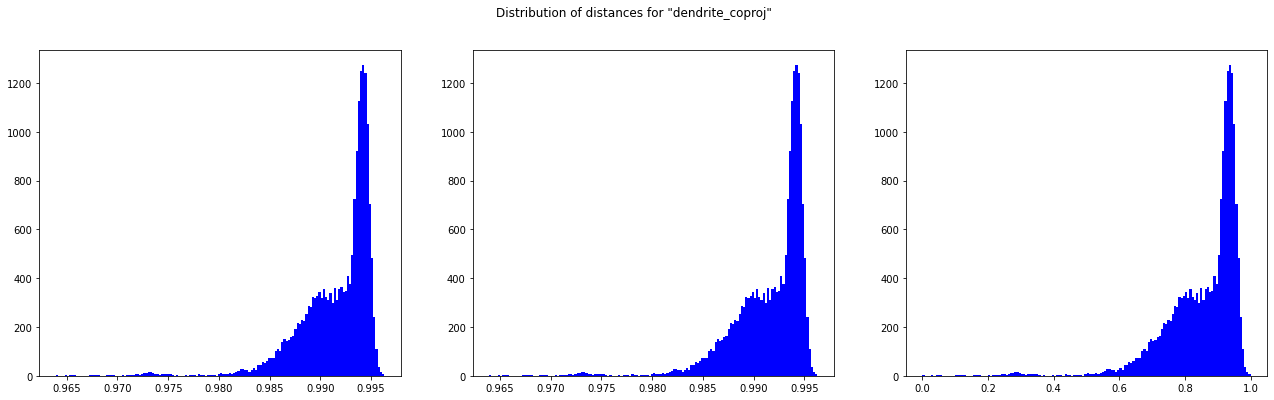

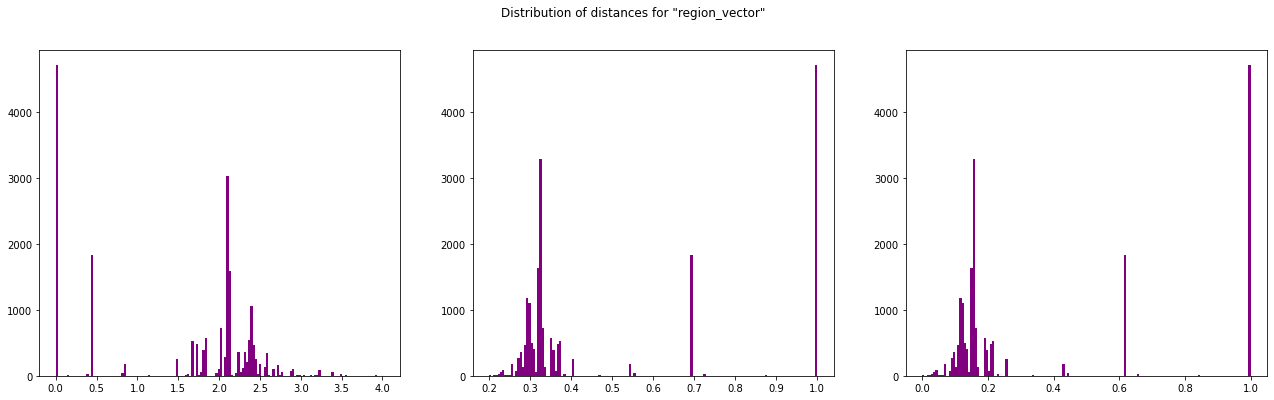

In [624]:
SCALERS = {}
for k in similarities:
    raw_values = np.array(similarities[k])
    if SIMILARITIES[k] == "cosine":
        scores = raw_values
        scaled_scores = raw_values
    else:
        scores = 1 / (1 + raw_values)
    
    scaler = sk.preprocessing.MinMaxScaler()
    scaled_scores = scaler.fit_transform(np.reshape(scores, (-1, 1)))
    SCALERS[k] = scaler

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle(f'Distribution of distances for "{k}"')
    ax1.hist(raw_values, bins=150, color=COLORS[k])
    ax2.hist(scores, bins=150, color=COLORS[k])
    ax3.hist(scaled_scores, bins=150, color=COLORS[k])
    plt.show()    

In [ ]:
SCALERS = {}
for k in similarities:
    raw_values = np.array(similarities[k]) 
#     raw_values = raw_values / raw_values.mean()
    X = np.reshape(raw_values, (-1, 1))
    log_dens = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X).score_samples(X)
    print(log_dens)
    plt.fill(X[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    plt.show()
    
    scaler = sk.preprocessing.MinMaxScaler()
    scaled_scores = scaler.fit_transform(np.reshape(scores, (-1, 1)))
    SCALERS[k] = scaler

#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
#     fig.suptitle(f'Distribution of distances for "{k}"')
#     ax1.hist(raw_values, bins=150, color=COLORS[k])
#     ax2.hist(scores, bins=150, color=COLORS[k])
#     ax3.hist(scaled_scores, bins=150, color=COLORS[k])
#     plt.show()  

Further 'equalization' of idividual similarity distributions can be done if we have some training set:

User considers that any two images in a given repository are similar given their similarity value $x_i$ (the subindex refers to using the ith basic similarity measure).

- $p(similar|x)$ the posterior probability
- $p(similar)$ the prior probability of images being similar 
- $p(x|similar)$ the conditional probability density function associated with similarity values

See https://www.sciencedirect.com/science/article/pii/S0167865508002511


Other fusion functions are discussed here:
https://pubs.acs.org/doi/pdf/10.1021/ci300547g

### Average aggregation

In [620]:
def get_average_score(indices, query, k,
                      distance_normalizer=None,
                      similarity_booster=None,
                      similarity_normalizer=None):
    if distance_normalizer is None:
        distance_normalizer = lambda x, index_name: x
    
    if similarity_normalizer is None:
        similarity_normalizer = lambda x, index_name: x
    
    if similarity_booster is None:
        similarity_booster = lambda x, index_name: x

    all_points = set()
    computed_scores = {}
    for index_name, index in indices.items():
        scores, points = query_index(index, [query], k)
        computed_scores[index_name] = {
            p: scores[0][i] for i, p in enumerate(points[0])
        }
        all_points.update(points[0])

    global_score = {p: [] for p in all_points}
    global_score_verbous = {p: dict() for p in all_points}
    for index_name, index in indices.items():
        for p in all_points:
            p_score = (
                computed_scores[index_name][p]
                if p in computed_scores[index_name]
                else compute_distance(index, query, int(p))
            )
            if SIMILARITIES[index_name] == "euclidean":
                p_score = 1 / (1 + p_score)

            p_score = similarity_booster(p_score, index_name)

            global_score[p].append(similarity_normalizer(
                p_score, index_name))
            global_score_verbous[p][index_name] = similarity_normalizer(
                p_score, index_name)

    print(global_score)
    df = pd.DataFrame([
        [point, sum(score) / len(indices)]
        for point, score in global_score.items()
    ])
    
    print(df.nlargest(k, columns=1))
    
    return dict(zip(
        df.nlargest(k, columns=1)[0].tolist(),
        df.nlargest(k, columns=1)[1].tolist()
    ))

In [617]:
get_average_score(INDICES, 0, K)

{0: [1.0, 1.0, 1.0000001, 1.0, 0.0], 1: [0.999027746760329, 0.9281646554075064, 0.9893038, 0.9941692352294922, 0.0], 130: [0.98106486983346, 0.9675284962221777, 0.9802758693695068, 0.992668867111206, 0.4428279595259351], 131: [0.9959870483464532, 0.8213344469043147, 0.9886335, 0.9939681887626648, 0.4428279595259351], 2: [0.9975031972740813, 0.9296837560192016, 0.9879000186920166, 0.993995189666748, 0.0], 5: [0.9985675914284154, 0.9050625871960162, 0.9827550649642944, 0.9943071603775024, 0.0], 6: [0.9996616021954452, 0.8778389564812636, 0.9657014608383179, 0.9937009811401367, 0.0], 7: [0.9997952294952668, 0.7620184931881252, 0.9910624, 0.9940067529678345, 0.0], 8: [0.9985788198233231, 0.9407173865977253, 0.9707120656967163, 0.9937735795974731, 0.0], 133: [0.9514642309072501, 0.975617462567415, 0.9697591066360474, 0.99178546667099, 2.035024492578096], 134: [0.9815184828051763, 0.9690840633067083, 0.9774481058120728, 0.9888423681259155, 0.4428279595259351], 11: [0.9996225993890302, 0.8722

{91: 1.2130266837931003,
 104: 1.2117052499496288,
 99: 1.2084081489194638,
 94: 1.206627074367478,
 112: 1.2056428900561886,
 88: 1.201559086358354,
 74: 1.1981920724219208,
 45: 1.191741320852244,
 83: 1.190993376135901,
 133: 1.1847301518719597,
 64: 1.180541624310885,
 119: 1.1684092819950795,
 126: 1.1150527961427525,
 113: 1.0893667083988334,
 92: 1.0735726025955759,
 153: 0.8815709957381689,
 117: 0.8804618508018169,
 125: 0.8745362015272141,
 130: 0.8728732124124571,
 134: 0.8719441959151617}

__Issues__:

    - similarity scores have different distributions, hard to compare)

In [341]:
avg_benchmarks = {
    p: get_average_score(
        INDICES, p, K,
        distance_normalizer=lambda x, index_name: x / MEANS[index_name],
        similarity_normalizer=lambda x, index_name: SCALERS[index_name].transform(np.atleast_2d(x))[0][0])
    for p in BENCHMARK_POINTS
}

Get details on each match

In [626]:
def min_max_scale(x, index_name):
    return SCALERS[index_name].transform(np.atleast_2d(x))[0][0]

In [627]:
query = 0
result = get_average_score(
    INDICES, query, 20,
    similarity_normalizer=min_max_scale)

{0: [1.0000735239579335, 1.0, 1.0267465, 1.1149101, -0.24886282207994265], 1: [0.9939185358892999, 0.8978191200275105, 0.9741705, 0.934708283596386, -0.24886282207994265], 130: [0.8802019766103406, 0.9538114997725702, 0.9297943279034335, 0.8883387122920254, 0.30416855314951935], 131: [0.9746689600647436, 0.7458604320804452, 0.97087556, 0.9284948494628402, 0.30416855314951935], 2: [0.9842671575086319, 0.8999799370758634, 0.9672700105472867, 0.9293293249038399, -0.24886282207994265], 5: [0.9910054568044684, 0.8649580030881312, 0.9419805461150821, 0.9389709241493129, -0.24886282207994265], 6: [0.9979312482991851, 0.8262342444946464, 0.8581553966951834, 0.920236674182469, -0.24886282207994265], 7: [0.998777195016034, 0.6614875320615172, 0.9828146, 0.9296866940772475, -0.24886282207994265], 8: [0.9910765397629673, 0.9156745243044841, 0.882784483768897, 0.9224803631165521, -0.24886282207994265], 133: [0.6928109019594642, 0.9653175028955865, 0.8781003164186103, 0.8610368127090773, 2.292603608

In [603]:
# scores = {}
# points = {}
# for index_name, index in INDICES.items():
#     s, p = query_index(index, [0], 200)
#     scores[index_name] = s[0]
#     points[index_name] = p[0]

Morphology 39 1.51
	 coordindates : 24/200
	 neurite_features : 25/200
	 axon_coproj : 43/200
	 dendrite_coproj : 190/200
	 region_vector : 131/200


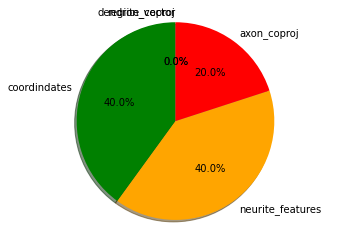

Morphology 74 1.50
	 coordindates : 77/200
	 neurite_features : 79/200
	 axon_coproj : 11/200
	 dendrite_coproj : 148/200
	 region_vector : 160/200


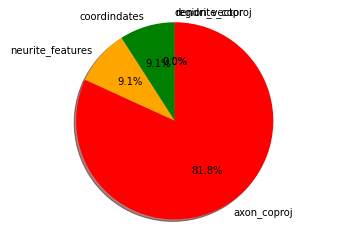

Morphology 91 1.50
	 coordindates : 141/200
	 neurite_features : 3/200
	 axon_coproj : 122/200
	 dendrite_coproj : 25/200
	 region_vector : 172/200


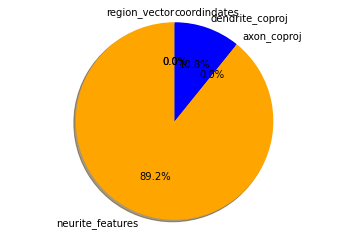

Morphology 104 1.49
	 coordindates : 163/200
	 neurite_features : 8/200
	 axon_coproj : 69/200
	 dendrite_coproj : 83/200
	 region_vector : 180/200


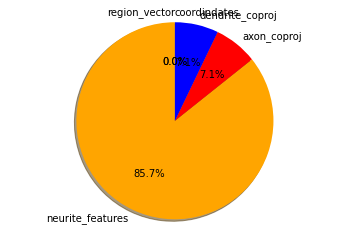

Morphology 101 1.48
	 coordindates : 157/200
	 neurite_features : 21/200
	 axon_coproj : 119/200
	 dendrite_coproj : 103/200
	 region_vector : 165/200


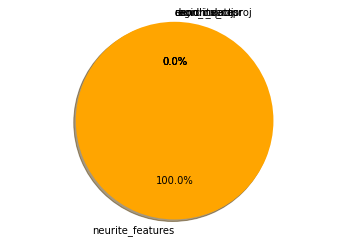

Morphology 106 1.48
	 coordindates : 162/200
	 neurite_features : 22/200
	 axon_coproj : 110/200
	 dendrite_coproj : 56/200
	 region_vector : 177/200


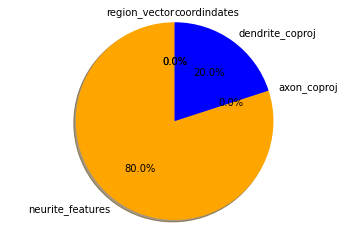

Morphology 99 1.48
	 coordindates : 171/200
	 neurite_features : 7/200
	 axon_coproj : 142/200
	 dendrite_coproj : 41/200
	 region_vector : 167/200


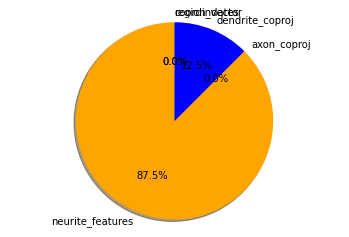

Morphology 94 1.47
	 coordindates : 172/200
	 neurite_features : 14/200
	 axon_coproj : 116/200
	 dendrite_coproj : 158/200
	 region_vector : 166/200


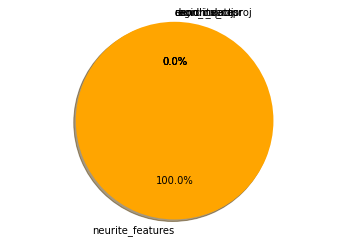

Morphology 88 1.47
	 coordindates : 166/200
	 neurite_features : 47/200
	 axon_coproj : 135/200
	 dendrite_coproj : 7/200
	 region_vector : 175/200


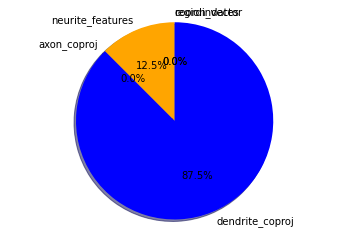

Morphology 112 1.46
	 coordindates : 173/200
	 neurite_features : 6/200
	 axon_coproj : 120/200
	 dendrite_coproj : 198/200
	 region_vector : 176/200


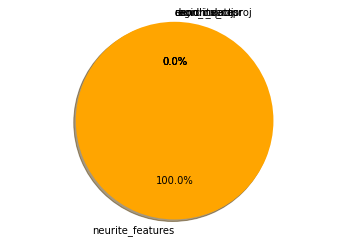

Morphology 42 1.45
	 coordindates : 126/200
	 neurite_features : 136/200
	 axon_coproj : 165/200
	 dendrite_coproj : 27/200
	 region_vector : 141/200


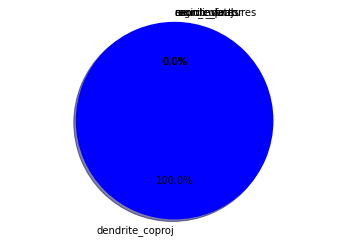

Morphology 133 1.44
	 coordindates : 178/200
	 neurite_features : 11/200
	 axon_coproj : 150/200
	 dendrite_coproj : 151/200
	 region_vector : 128/200


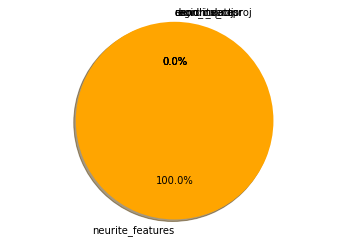

Morphology 113 1.43
	 coordindates : 19/200
	 neurite_features : 159/200
	 axon_coproj : 94/200
	 dendrite_coproj : 121/200
	 region_vector : 120/200


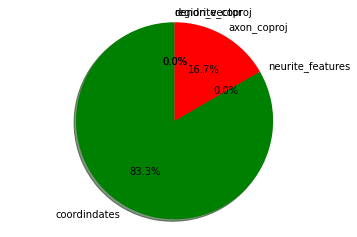

Morphology 153 1.43
	 coordindates : 57/200
	 neurite_features : 4/200
	 axon_coproj : 21/200
	 dendrite_coproj : 124/200
	 region_vector : 107/200


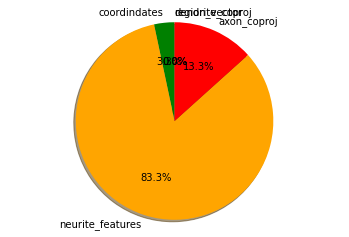

Morphology 0 1.43
	 coordindates : 1/200
	 neurite_features : 1/200
	 axon_coproj : 1/200
	 dendrite_coproj : 1/200
	 region_vector : 25/200


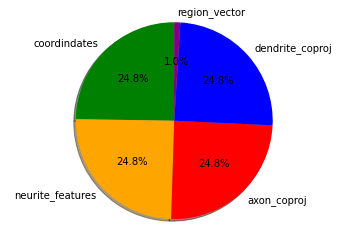

Morphology 45 1.43
	 coordindates : 103/200
	 neurite_features : 12/200
	 axon_coproj : 185/200
	 dendrite_coproj : 107/200
	 region_vector : 153/200


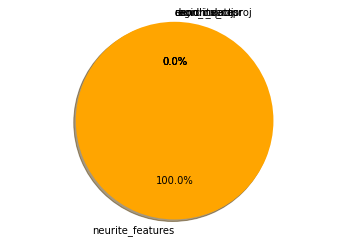

Morphology 83 1.43
	 coordindates : 122/200
	 neurite_features : 13/200
	 axon_coproj : 184/200
	 dendrite_coproj : 61/200
	 region_vector : 140/200


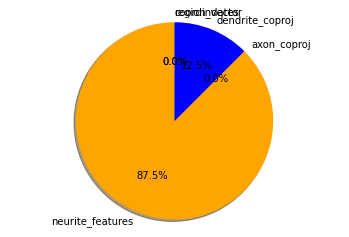

Morphology 117 1.42
	 coordindates : 84/200
	 neurite_features : 2/200
	 axon_coproj : 63/200
	 dendrite_coproj : 136/200
	 region_vector : 90/200


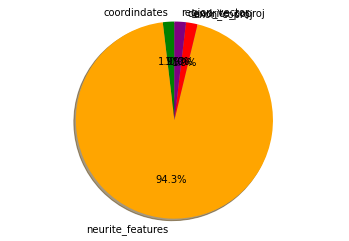

Morphology 79 1.42
	 coordindates : 145/200
	 neurite_features : 30/200
	 axon_coproj : 177/200
	 dendrite_coproj : 161/200
	 region_vector : 164/200


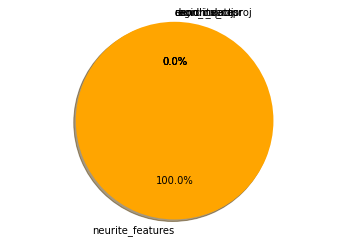

Morphology 63 1.42
	 coordindates : 105/200
	 neurite_features : 28/200
	 axon_coproj : 194/200
	 dendrite_coproj : 101/200
	 region_vector : 146/200


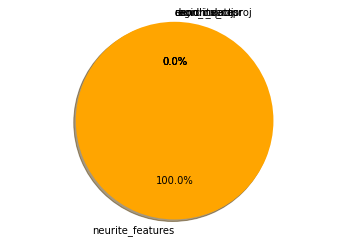

Morphology 64 1.42
	 coordindates : 110/200
	 neurite_features : 90/200
	 axon_coproj : 172/200
	 dendrite_coproj : 4/200
	 region_vector : 162/200


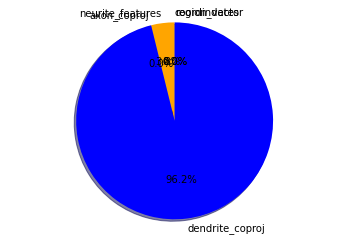

Morphology 61 1.41
	 coordindates : 118/200
	 neurite_features : 23/200
	 axon_coproj : 199/200
	 dendrite_coproj : 58/200
	 region_vector : 158/200


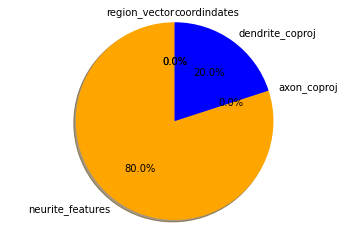

Morphology 116 1.41
	 coordindates : 93/200
	 neurite_features : 61/200
	 axon_coproj : 25/200
	 dendrite_coproj : 144/200
	 region_vector : 98/200


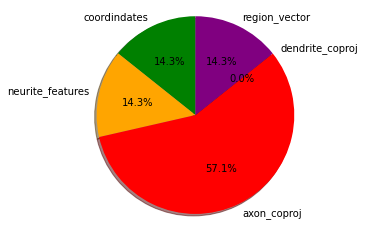

Morphology 92 1.41
	 coordindates : 117/200
	 neurite_features : 178/200
	 axon_coproj : 53/200
	 dendrite_coproj : 11/200
	 region_vector : 123/200


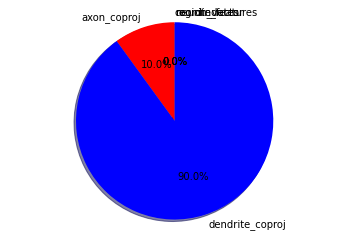

Morphology 139 1.40
	 coordindates : 51/200
	 neurite_features : 109/200
	 axon_coproj : 30/200
	 dendrite_coproj : 16/200
	 region_vector : 105/200


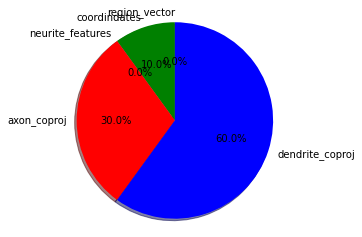

Morphology 163 1.40
	 coordindates : 106/200
	 neurite_features : 99/200
	 axon_coproj : 24/200
	 dendrite_coproj : 42/200
	 region_vector : 89/200


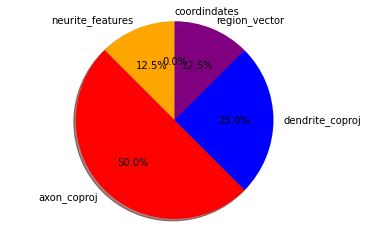

Morphology 174 1.40
	 coordindates : 78/200
	 neurite_features : 18/200
	 axon_coproj : 13/200
	 dendrite_coproj : 5/200
	 region_vector : 83/200


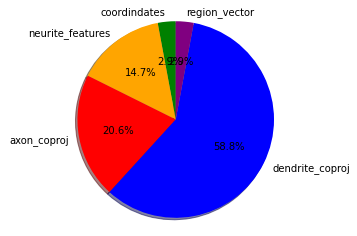

Morphology 26 1.40
	 coordindates : 63/200
	 neurite_features : 24/200
	 axon_coproj : 4/200
	 dendrite_coproj : 116/200
	 region_vector : 23/200


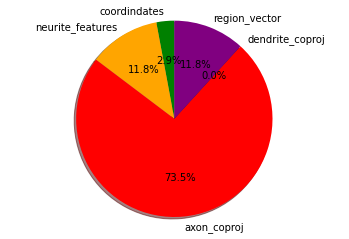

Morphology 188 1.40
	 coordindates : 35/200
	 neurite_features : 19/200
	 axon_coproj : 51/200
	 dendrite_coproj : 60/200
	 region_vector : 45/200


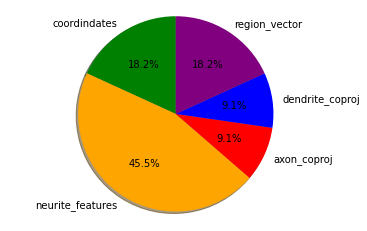

Morphology 189 1.40
	 coordindates : 16/200
	 neurite_features : 36/200
	 axon_coproj : 29/200
	 dendrite_coproj : 118/200
	 region_vector : 22/200


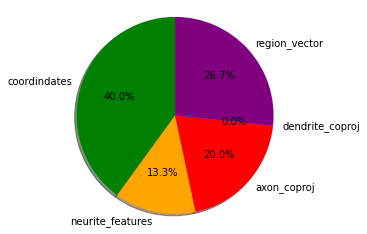

In [401]:
for el, score in result.items():
    print("Morphology", el, "{:.2f}".format(score))
    labels = []
    aspect_scores = []
    for index_name, index in INDICES.items():
        scores, points = query_index(index, [query], 200)
        position = np.where(points[0] == el)[0]
        
        if len(position) > 0:
            position = position[0]
            print("\t", index_name, f": {position + 1}/200")
            labels.append(index_name)
            aspect_scores.append(int(100 * (1 / (position + 1))))
    
    
    fig1, ax1 = plt.subplots()
    ax1.pie(aspect_scores, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=[COLORS[el] for el in labels])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

In [348]:
avg_minus_benchmarks = {
    p: get_average_score(
        {k: v for k, v in INDICES.items() if k != "coordindates"}, p, K,
        distance_normalizer=lambda x, index_name: x / MEANS[index_name],
        similarity_normalizer=lambda x, index_name:  SCALERS[index_name].transform(np.atleast_2d(x))[0][0])
    for p in BENCHMARK_POINTS
}

__Note__ Average can be weighted by user preference specified though some kind of interface

### Compare overlaps with individual indices

(for example, to see if there is one of them that dominates)

In [349]:
def compare_to_individual(benchmark, individual_benchmarks):
    stats = defaultdict(list)
    for index_name, other_benchmark in individual_benchmarks.items():
        for p in benchmark:
            stats[index_name].append(
                len(set(benchmark[p]).intersection(set(other_benchmark[p]))) / len(benchmark[p]))
    for k, v in stats.items():
        print(k, ": {:.2f}+-{:.2f}".format(np.array(v).mean(), np.array(v).std()))

In [350]:
compare_to_individual(concatenated_benchmarks, individual_benchmarks)

coordindates : 0.35+-0.15
neurite_features : 0.33+-0.15
axon_coproj : 0.43+-0.13
dendrite_coproj : 0.18+-0.08
region_vector : 0.34+-0.21


In [351]:
compare_to_individual(concatenated_minus_benchmarks, individual_benchmarks)

coordindates : 0.28+-0.08
neurite_features : 0.33+-0.15
axon_coproj : 0.41+-0.14
dendrite_coproj : 0.17+-0.09
region_vector : 0.25+-0.14


In [352]:
compare_to_individual(avg_benchmarks, individual_benchmarks)

coordindates : 0.35+-0.17
neurite_features : 0.55+-0.12
axon_coproj : 0.32+-0.13
dendrite_coproj : 0.35+-0.11
region_vector : 0.12+-0.10


In [353]:
compare_to_individual(avg_minus_benchmarks, individual_benchmarks)

coordindates : 0.19+-0.12
neurite_features : 0.58+-0.11
axon_coproj : 0.31+-0.11
dendrite_coproj : 0.40+-0.11
region_vector : 0.10+-0.09


In [354]:
compare_to_individual(
    concatenated_benchmarks, {
        "concat-": concatenated_minus_benchmarks,
        "avg": avg_benchmarks,
        "avg-": avg_minus_benchmarks
    })

concat- : 0.80+-0.18
avg : 0.31+-0.16
avg- : 0.26+-0.18


In [355]:
compare_to_individual(
    avg_benchmarks, {
        "avg-": avg_minus_benchmarks
    })

avg- : 0.77+-0.12


## Adding density normalization

In [356]:
def plot_with_densities(vectors=None, labels=None,
                        title=None, silent=False, indices_to_mark=None,
                        marker_labels=None):
    """Plot a 2D representation of nodes."""
    if indices_to_mark is None:
        indices_to_mark = []
        
    if marker_labels is None:
        marker_labels = [str(el) for el in indices_to_mark]

    if vectors is None:
        raise ValueError(
            "Vectors to plot are not specified")

    unlabeled = False
    if labels is None:
        labels = [0] * vectors.shape[0]
        unlabeled = True

    # Generate color map
    unique_labels = set(labels)
    cm = plt.get_cmap('gist_rainbow')
    generated_colors = np.array([
        cm(1. * i / len(unique_labels))
        for i in range(len(unique_labels))
    ])
    np.random.shuffle(generated_colors)

    alpha = 1
    fig, ax = plt.subplots(figsize=(7, 7))

    # create a scatter per node label
    for i, l in enumerate(unique_labels):
        indices = np.where(np.array(labels) == l)
        ax.scatter(
            vectors[indices, 0],
            vectors[indices, 1],
            c=[generated_colors[i]] * indices[0].shape[0],
            cmap="jet",
            s=50,
            alpha=0.5,
            label=l if not unlabeled else None
        )
        
    if not unlabeled:
        ax.legend()
       
    # mark selected points
    offset = max(
        max(vectors[0]) - min(vectors[0]),
        max(vectors[1]) - min(vectors[1])) * 0.2

    if len(indices_to_mark) > 0:
        ax.scatter(
            vectors[indices_to_mark, 0],
            vectors[indices_to_mark, 1],
            c="black",
            s=150,
            marker="P",
            alpha=alpha,
            label=l if not unlabeled else None
        )
        for i, el in enumerate(indices_to_mark):
            ax.text(
                vectors[el, 0] + offset, vectors[el, 1] + offset, marker_labels[i])

    title = (
        title
        if title is not None
        else "2D visualization of the input node representation"
    )
    ax.set_title(title)
    if not silent:
        plt.show()

In [357]:
def get_gaussian_deviation(query, k, index_name):
    raw_scores, points = query_index(INDICES[index_name], [query], k)
    
    if SIMILARITIES[index_name] == "euclidean":
        scores = 1 / (1 + raw_scores[0][1:])
    else:
        scores = raw_scores[0][1:]
    
    scores = np.array([
        min_max_scale(el, index_name)
        for el in scores
    ])
    
    return math.sqrt(((1 - scores)**2).mean()), points[0]

In [358]:
selected_points = np.random.choice(range(200), 10)

In [359]:
coord_deviation = {p: get_gaussian_deviation(int(p), 20, "coordindates") for p in selected_points}

0.9025679441411801


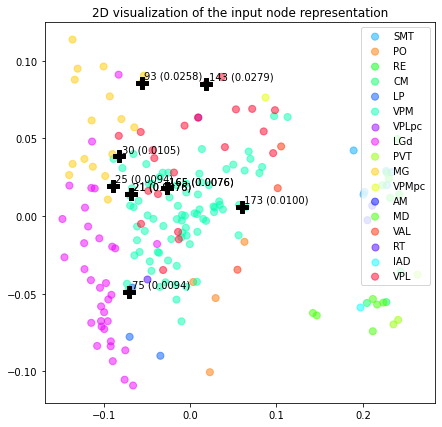

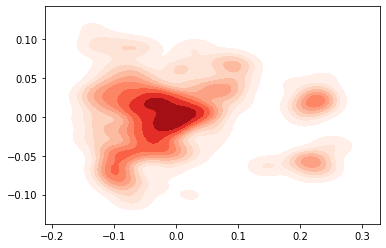

In [360]:
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["coordinates"].tolist())
print(sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"], indices_to_mark=selected_points, marker_labels=[
        "{} ({:.4f})".format(el, coord_deviation[el][0]) for el in selected_points
    ])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

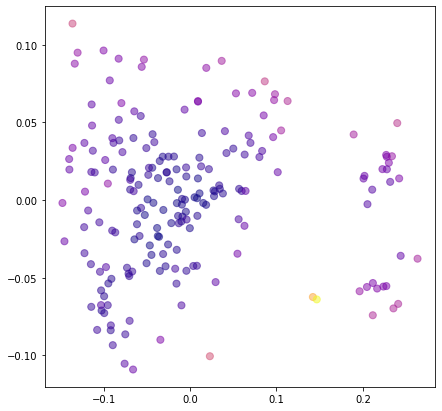

In [361]:
densities = [
    get_gaussian_deviation(i, 20, "coordindates")[0] for i in range(embedding_2d.shape[0])
]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=densities,
    cmap="plasma",
    s=50,
    alpha=0.5
)
plt.show()

In [362]:
n_deviation = {p: get_gaussian_deviation(int(p), 20, "neurite_features") for p in selected_points}

0.7079793581524594


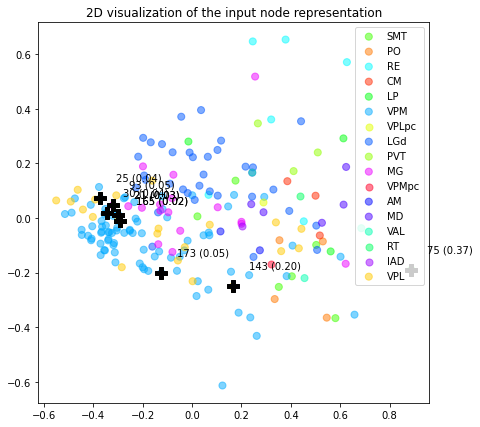

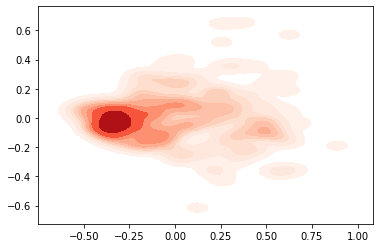

In [363]:
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["neurite_features"].tolist())
print(sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"], indices_to_mark=selected_points, marker_labels=[
        "{} ({:.2f})".format(el, n_deviation[el][0]) for el in selected_points
    ])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

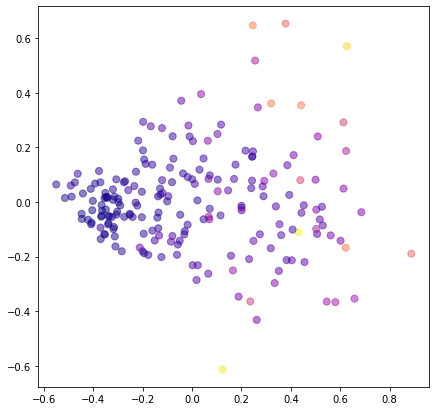

In [364]:
densities = [
    get_gaussian_deviation(i, 20, "neurite_features")[0] for i in range(embedding_2d.shape[0])
]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=densities,
    cmap="plasma",
    s=50,
    alpha=0.5
)
plt.show()

In [365]:
a_deviation = {p: get_gaussian_deviation(int(p), 20, "axon_coproj") for p in selected_points}

0.7565479306458232


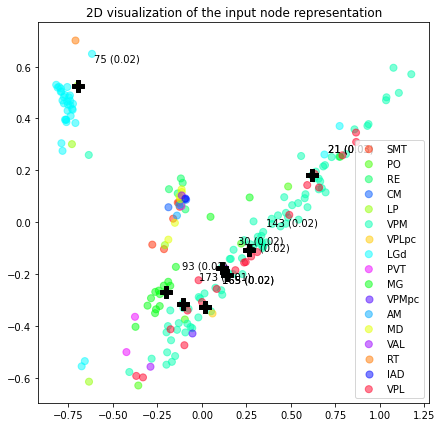

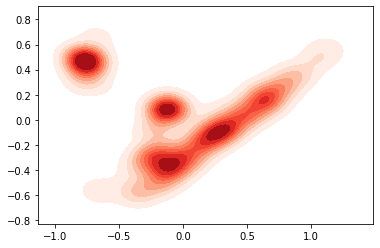

In [366]:
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["axon_coproj_embedding"].tolist())
print(sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"], indices_to_mark=selected_points, marker_labels=[
        "{} ({:.2f})".format(el, a_deviation[el][0]) for el in selected_points
    ])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

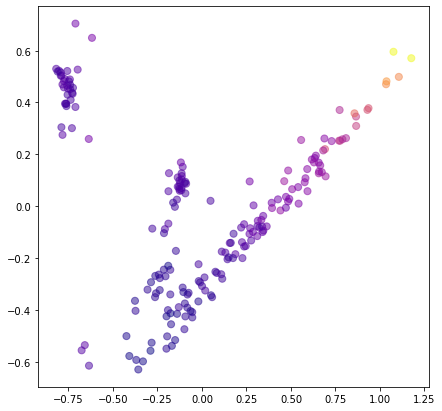

In [367]:
densities = [
    get_gaussian_deviation(i, 20, "axon_coproj")[0] for i in range(embedding_2d.shape[0])
]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=densities,
    cmap="plasma",
    s=50,
    alpha=0.5
)
plt.show()

In [368]:
d_deviation = {p: get_gaussian_deviation(int(p), 20, "dendrite_coproj") for p in selected_points}

0.6206337416829124


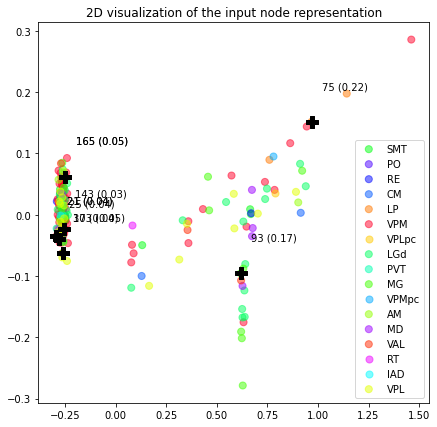

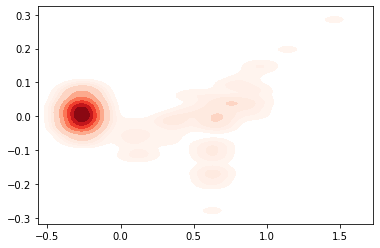

In [369]:
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["dendrite_coproj_embedding"].tolist())
print(sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"], indices_to_mark=selected_points, marker_labels=[
        "{} ({:.2f})".format(el, d_deviation[el][0]) for el in selected_points
    ])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

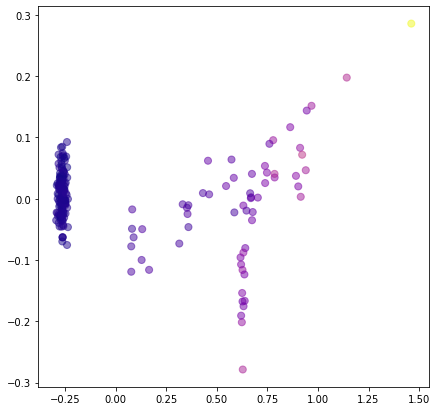

In [370]:
densities = [
    get_gaussian_deviation(i, 20, "dendrite_coproj")[0] for i in range(embedding_2d.shape[0])
]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=densities,
    cmap="plasma",
    s=50,
    alpha=0.5
)
plt.show()

In [372]:
r_deviation = {p: get_gaussian_deviation(int(p), 20, "region_vector") for p in selected_points}

0.6753429538285397


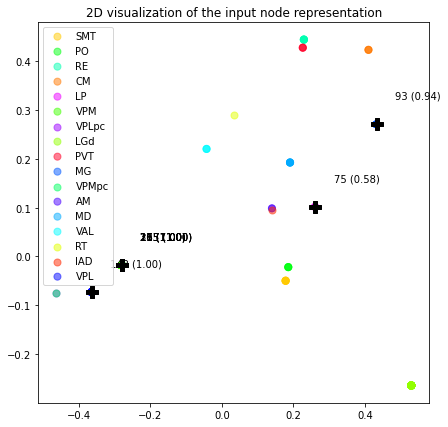

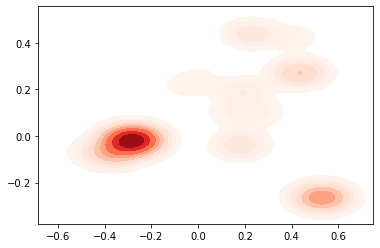

In [378]:
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["region_vector"].tolist())
print(sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"], indices_to_mark=selected_points, marker_labels=[
        "{} ({:.2f})".format(el, r_deviation[el][0]) for el in selected_points
    ])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

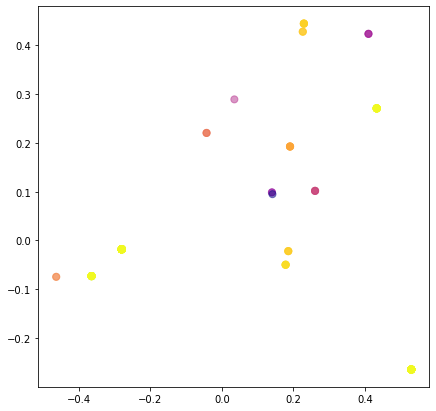

In [383]:
densities = [
    get_gaussian_deviation(i, 10, "region_vector")[0] for i in range(embedding_2d.shape[0])
]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=densities,
    cmap="plasma",
    s=50,
    alpha=0.5
)
plt.show()

### Use local density boosting when computing similarity scores

In [384]:
def get_boost_factor(query, index_name, k):
    boost, _ = get_gaussian_deviation(query, k, index_name)
    return boost

In [386]:
boosts = {}
pairwise_similarities = {}
points = list(range(data.shape[0]))
boosted_similarities = defaultdict(list)
for index_name, index in INDICES.items():
    boosts[index_name] = {}
    pairwise_similarities[index_name] = {}
    for p1 in points:
        for p2 in points:
            if p1 < p2:
                d = compute_distance(index, p1, p2)
                if SIMILARITIES[index_name] == "euclidean":
                    d = 1 / (1 + d)
                pairwise_similarities[index_name][(p1, p2)] = d
                if p1 in boosts[index_name]:
                    factor1 = boosts[index_name][p1]
                else:
                    factor1 = get_boost_factor(p1, index_name, 20)
                    boosts[index_name][p1] = factor1
                if p2 in boosts[index_name]:
                    factor2 = boosts[index_name][p2]
                else:
                    factor2 = get_boost_factor(p2, index_name, 20)
                    boosts[index_name][p2] = factor2
                boosted_similarities[index_name].append((d, factor1, factor2))

In [571]:
boosts["dendrite_coproj"]

{0: 0.04279046976957607,
 1: 0.030983986611295793,
 2: 0.03980551034677712,
 3: 0.1533784027363372,
 4: 0.0352902210846434,
 5: 0.038890386431929005,
 6: 0.044743773114234005,
 7: 0.04141465716887649,
 8: 0.04026736323727674,
 9: 0.04385104399934729,
 10: 0.02789943881041932,
 11: 0.02802996772684726,
 12: 0.038633988346145044,
 13: 0.042364148950638066,
 14: 0.1731608258888676,
 15: 0.04241992346391561,
 16: 0.06914431998514384,
 17: 0.031686263372059605,
 18: 0.04287780408328039,
 19: 0.038467207487829315,
 20: 0.0446880021308818,
 21: 0.041252681586765226,
 22: 0.039601986022354436,
 23: 0.0432619473729002,
 24: 0.03661283717857331,
 25: 0.04037444301261999,
 26: 0.09493239642728168,
 27: 0.03974695474221639,
 28: 0.03296107003006079,
 29: 0.04300201818739609,
 30: 0.03710492791332771,
 31: 0.21413096182396194,
 32: 0.04433021203853766,
 33: 0.03257117466575803,
 34: 0.07287558039520799,
 35: 0.13084718305813844,
 36: 0.053954404938929994,
 37: 0.03846968750359413,
 38: 0.2325873787

In [589]:
from scipy import stats
import numpy as np

X = np.array(list(boosts["dendrite_coproj"].values()))
z = np.abs(stats.zscore(X))
outlier = np.where(z > 3)[0][0]
X[outlier] = sorted(X)[-2]

In [590]:
max(X)

0.2812477747511253

In [580]:
z[z > 3]

array([7.71734274])

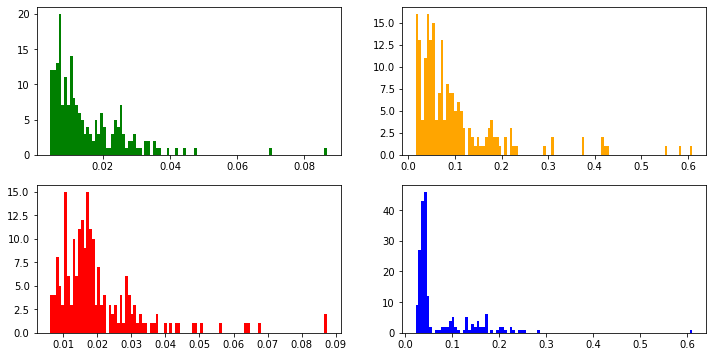

In [387]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))

ax1.hist(boosts["coordindates"].values(), color=COLORS["coordindates"], bins=100)
ax2.hist(boosts["neurite_features"].values(), color=COLORS["neurite_features"], bins=100)
ax3.hist(boosts["axon_coproj"].values(), color=COLORS["axon_coproj"], bins=100)
ax4.hist(boosts["dendrite_coproj"].values(), color=COLORS["dendrite_coproj"], bins=100)
plt.show()

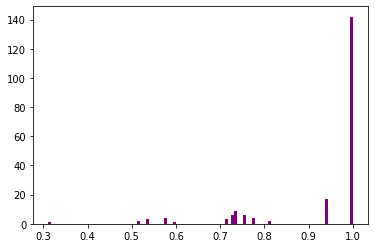

In [389]:
plt.hist(boosts["region_vector"].values(), color=COLORS["region_vector"], bins=100)
plt.show()

In [390]:
most_similar_pair = {}
old_similar_boosted = {}
most_similar_boosted_pair = {}
for index_name in pairwise_similarities:
    raw = {}
    boosted = {}
    for (s, t), sim in pairwise_similarities[index_name].items():
        from_s = boosts[index_name][s] + sim
        from_t = boosts[index_name][t] + sim
        raw[(s, t)] = sim
        boosted[(s, t)] = from_s
        boosted[(t, s)] = from_t
    max_value = max(raw.values())
    max_boosted_value = max(boosted.values())
    most_similar_pair[index_name] = ([
        k for k, v in raw.items() if v == max_value][0], max_value)
    old_similar_boosted[index_name] = boosted[
        (most_similar_pair[index_name][0][0],
         most_similar_pair[index_name][0][1])]
    most_similar_boosted_pair[index_name] = (
        [k for k, v in boosted.items() if v == max_boosted_value][0], max_boosted_value)

Explained variance of 2d repr: 0.9025679441411801


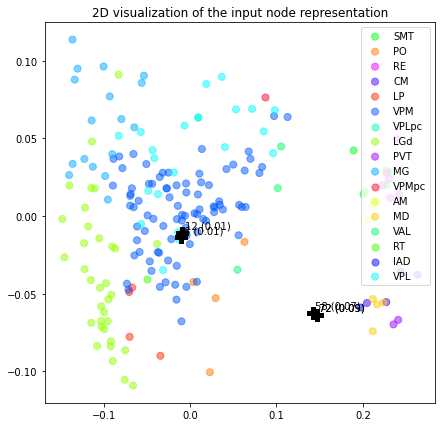

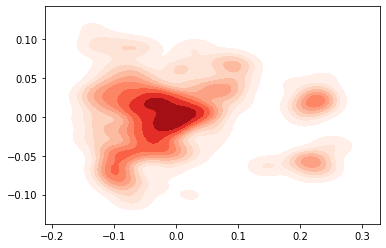

In [391]:
largest_boost = [k for k, v in boosts["coordindates"].items() if v == max(boosts["coordindates"].values())] + list(
    most_similar_pair["coordindates"][0] + most_similar_boosted_pair["coordindates"][0])
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["coordinates"].tolist())
print("Explained variance of 2d repr:", sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"],
    indices_to_mark=largest_boost,
    marker_labels=[
        "{} ({:.2f})".format(el, boosts["coordindates"][el])
        for el in largest_boost
    ])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

0.7079793581524594


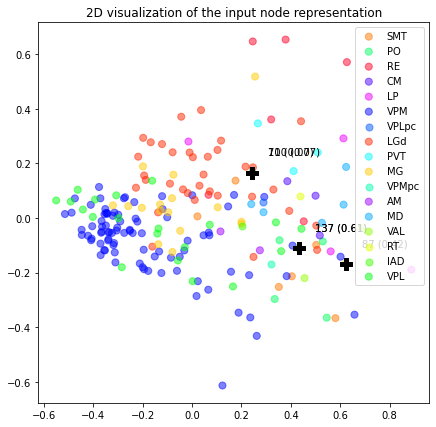

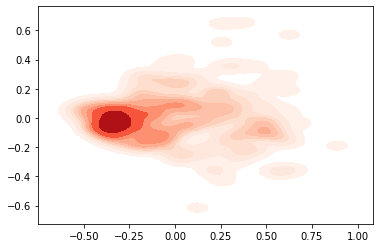

In [392]:
largest_boost = [k for k, v in boosts["neurite_features"].items() if v == max(boosts["neurite_features"].values())]  + list(
    most_similar_pair["neurite_features"][0] + most_similar_boosted_pair["neurite_features"][0])
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["neurite_features"].tolist())
print(sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"],
    indices_to_mark=largest_boost,
    marker_labels=[
        "{} ({:.2f})".format(el, boosts["neurite_features"][el])
        for el in  largest_boost
    ])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

0.7565479306458232


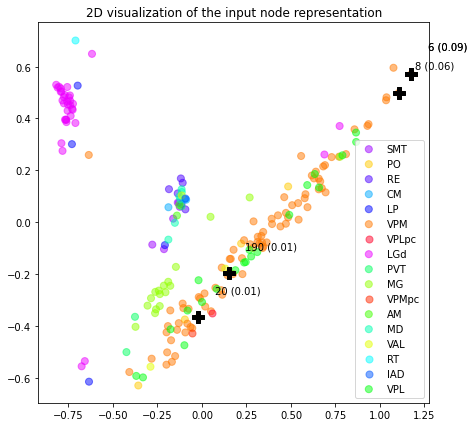

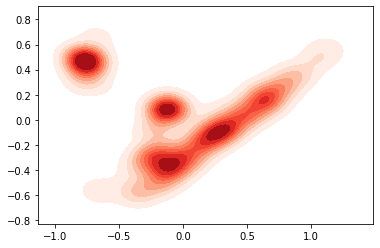

In [393]:
largest_boost = [k for k, v in boosts["axon_coproj"].items() if v == max(boosts["axon_coproj"].values())] + list(
    most_similar_pair["axon_coproj"][0]) + list(most_similar_boosted_pair["axon_coproj"][0])
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["axon_coproj_embedding"].tolist())
print(sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"],
    indices_to_mark=largest_boost,
    marker_labels=["{} ({:.2f})".format(el, boosts["axon_coproj"][el])
                  for el in largest_boost])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

0.6206337416829124


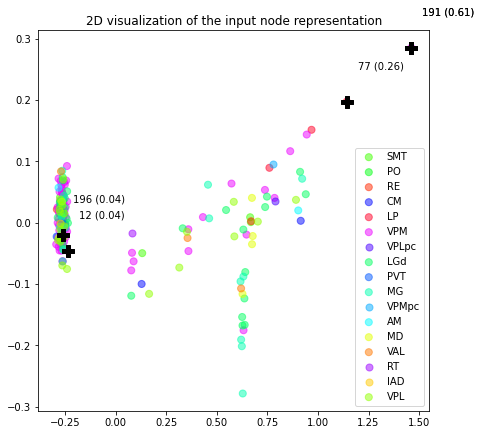

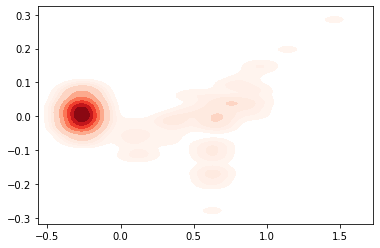

In [394]:
largest_boost = [k for k, v in boosts["dendrite_coproj"].items() if v == max(boosts["dendrite_coproj"].values())] + list(
    most_similar_pair["dendrite_coproj"][0]) + list(most_similar_boosted_pair["dendrite_coproj"][0])
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(data["dendrite_coproj_embedding"].tolist())
print(sum(pca.explained_variance_ratio_))
plot_with_densities(
    embedding_2d, data["brain_region"],
    indices_to_mark=largest_boost,
    marker_labels=[
        "{} ({:.2f})".format(el, boosts["dendrite_coproj"][el])
        for el in largest_boost
    ])
sns.kdeplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

Max similarity value 1.0860978985090484


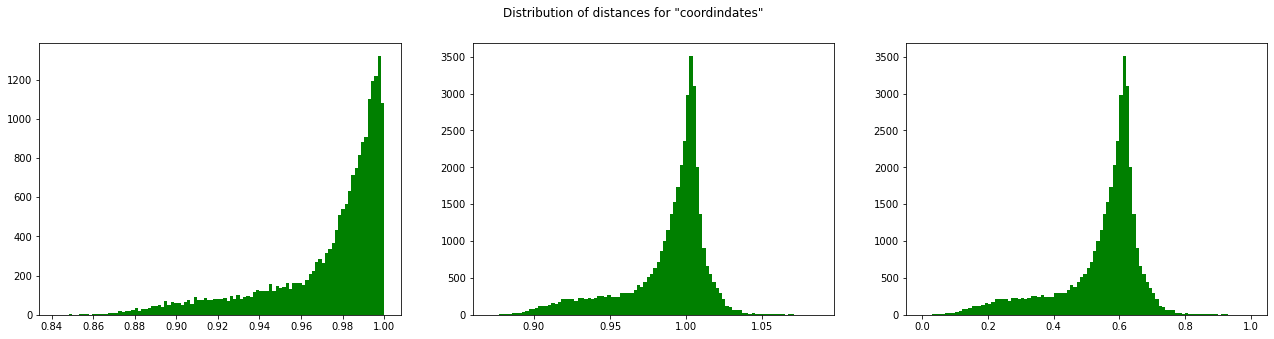

Max similarity value 1.3466259442091744


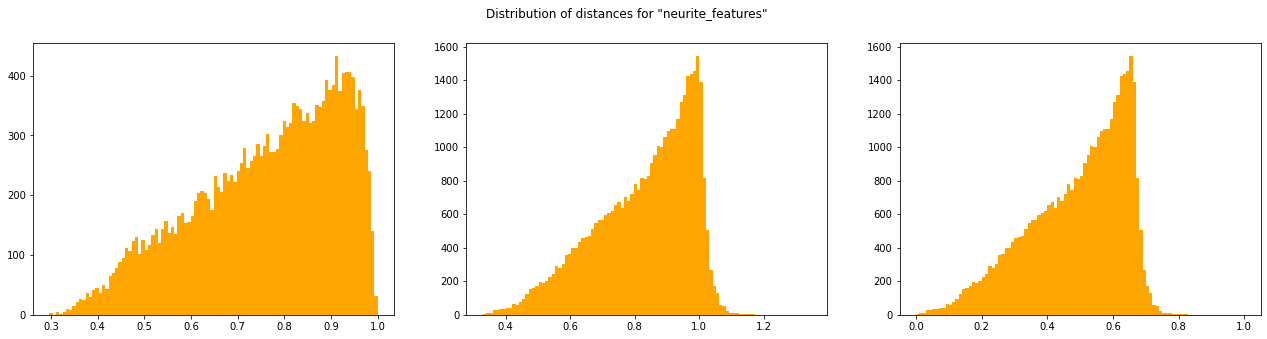

Max similarity value 1.0729900277506865


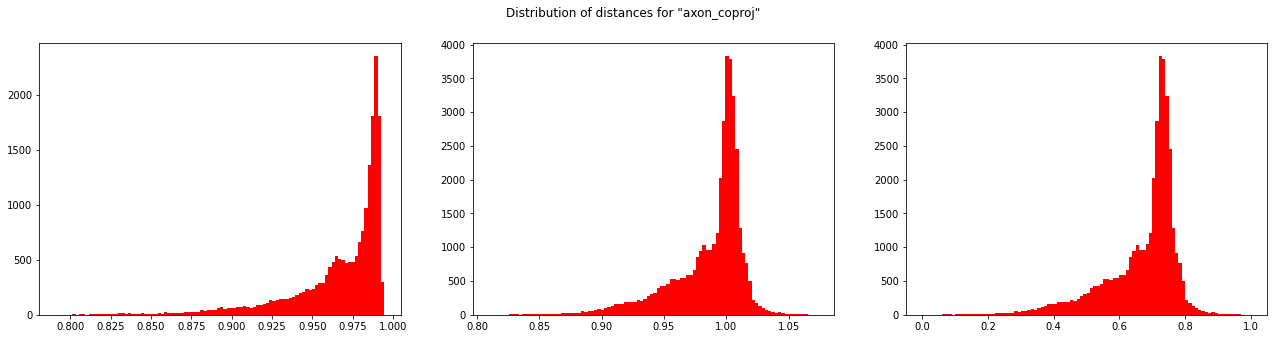

Max similarity value 1.5794309773222006


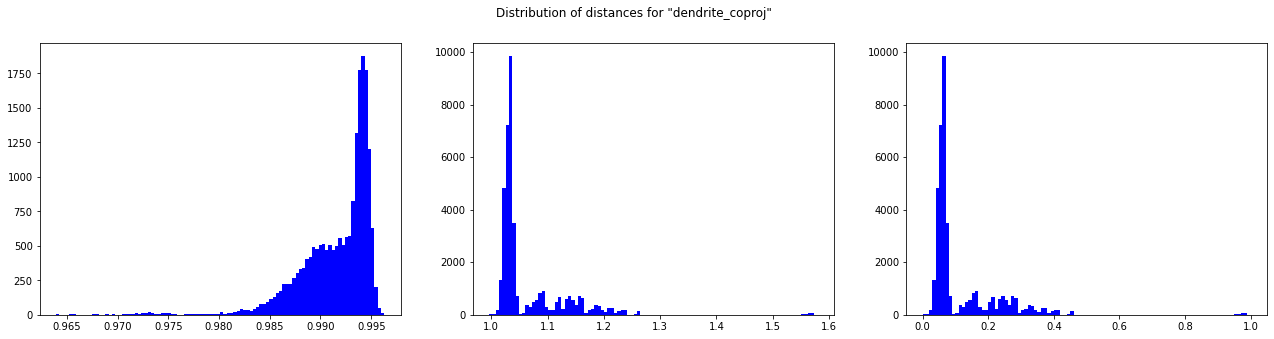

Max similarity value 7.279928869872445


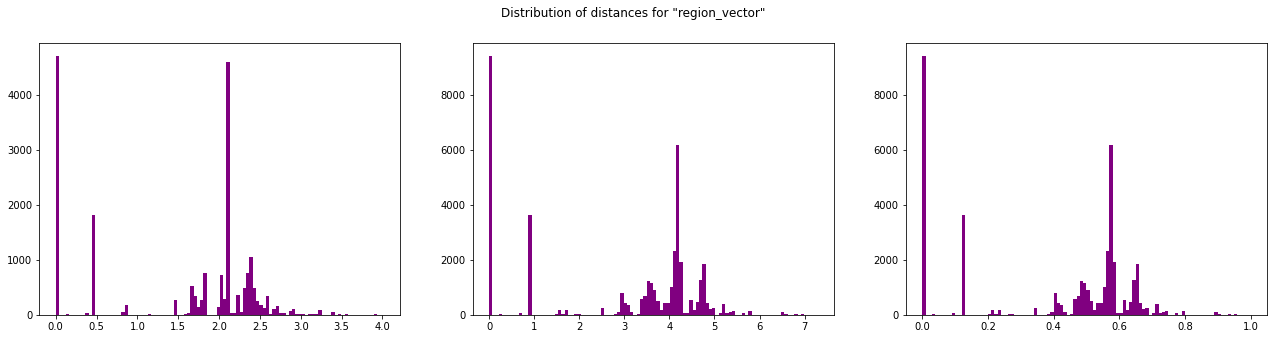

In [591]:
BOOSTED_SCALERS = {}

for k in boosted_similarities:

    
    raw_values = np.array([score for score, _, _ in boosted_similarities[k]])
    boost_factor_1 = np.array(
        [factor for _, factor, _ in boosted_similarities[k]])
    boost_factor_2 = np.array(
        [factor for _, _, factor in boosted_similarities[k]])

#     print(boost_factor_1)
#     if k == "dendrite_coproj":
#         print(raw_sim_values.std())

    sim_values1 = raw_values * (1 + boost_factor_1)
    sim_values2 = raw_values * (1 + boost_factor_2)

    sim_values = np.hstack([sim_values1, sim_values2])
    print("Max similarity value", max(sim_values))

    scaler = sk.preprocessing.MinMaxScaler()
    scaled_values = scaler.fit_transform(np.reshape(sim_values, (-1, 1)))
    BOOSTED_SCALERS[k] = scaler

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))
    fig.suptitle(f'Distribution of distances for "{k}"')
    ax1.hist(raw_values, bins=100, color=COLORS[k])
    ax2.hist(sim_values, bins=100, color=COLORS[k])
    ax3.hist(scaled_values, bins=100, color=COLORS[k])
    plt.show()

In [396]:
def min_max_scale(x, index_name):
    return BOOSTED_SCALERS[index_name].transform(np.atleast_2d(x))[0][0]

In [399]:
query = 0
result = get_average_score(
    INDICES, query, 30,
    similarity_booster=lambda x, index_name: x * (1 + get_boost_factor(0, index_name, 20)),
    similarity_normalizer=min_max_scale)

Morphology 39 1.51
	 coordindates : 24/50
	 neurite_features : 25/50
	 axon_coproj : 43/50
	 dendrite_coproj : 190/50
	 region_vector : 131/50


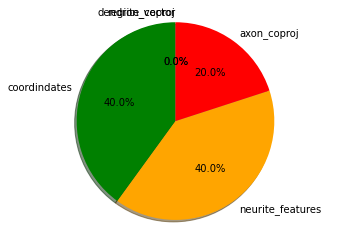

Morphology 74 1.50
	 coordindates : 77/50
	 neurite_features : 79/50
	 axon_coproj : 11/50
	 dendrite_coproj : 148/50
	 region_vector : 160/50


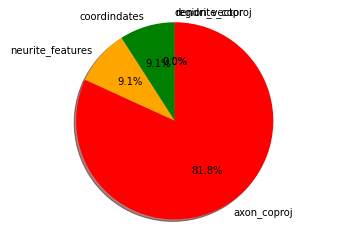

Morphology 91 1.50
	 coordindates : 141/50
	 neurite_features : 3/50
	 axon_coproj : 122/50
	 dendrite_coproj : 25/50
	 region_vector : 172/50


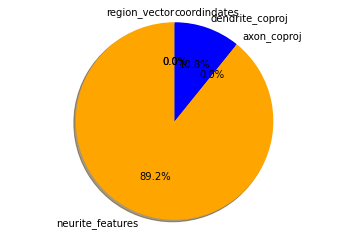

Morphology 104 1.49
	 coordindates : 163/50
	 neurite_features : 8/50
	 axon_coproj : 69/50
	 dendrite_coproj : 83/50
	 region_vector : 180/50


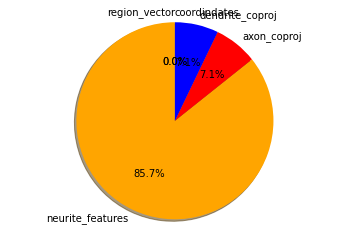

Morphology 101 1.48
	 coordindates : 157/50
	 neurite_features : 21/50
	 axon_coproj : 119/50
	 dendrite_coproj : 103/50
	 region_vector : 165/50


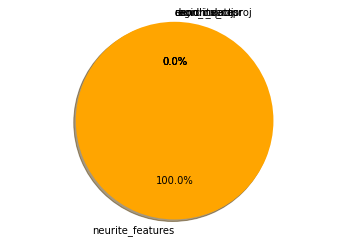

Morphology 106 1.48
	 coordindates : 162/50
	 neurite_features : 22/50
	 axon_coproj : 110/50
	 dendrite_coproj : 56/50
	 region_vector : 177/50


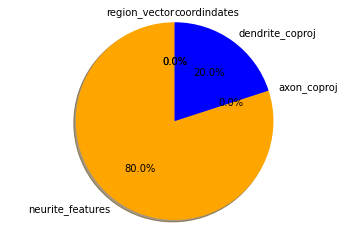

Morphology 99 1.48
	 coordindates : 171/50
	 neurite_features : 7/50
	 axon_coproj : 142/50
	 dendrite_coproj : 41/50
	 region_vector : 167/50


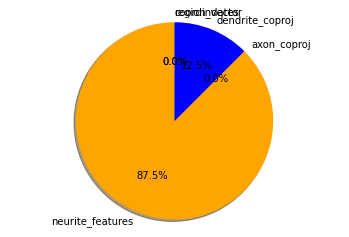

Morphology 94 1.47
	 coordindates : 172/50
	 neurite_features : 14/50
	 axon_coproj : 116/50
	 dendrite_coproj : 158/50
	 region_vector : 166/50


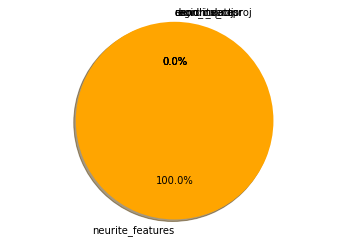

Morphology 88 1.47
	 coordindates : 166/50
	 neurite_features : 47/50
	 axon_coproj : 135/50
	 dendrite_coproj : 7/50
	 region_vector : 175/50


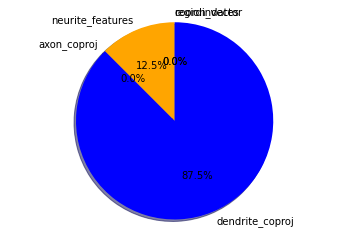

Morphology 112 1.46
	 coordindates : 173/50
	 neurite_features : 6/50
	 axon_coproj : 120/50
	 dendrite_coproj : 198/50
	 region_vector : 176/50


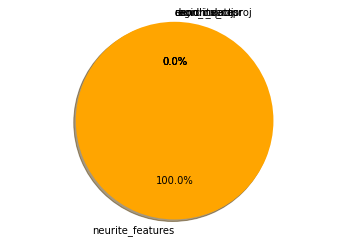

Morphology 42 1.45
	 coordindates : 126/50
	 neurite_features : 136/50
	 axon_coproj : 165/50
	 dendrite_coproj : 27/50
	 region_vector : 141/50


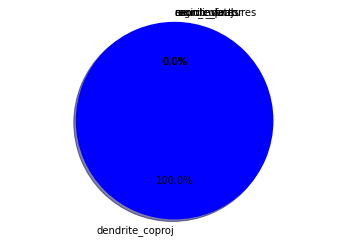

Morphology 133 1.44
	 coordindates : 178/50
	 neurite_features : 11/50
	 axon_coproj : 150/50
	 dendrite_coproj : 151/50
	 region_vector : 128/50


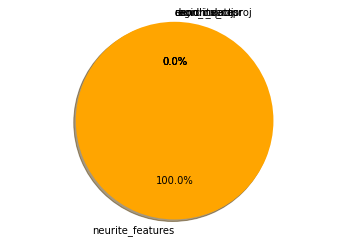

Morphology 113 1.43
	 coordindates : 19/50
	 neurite_features : 159/50
	 axon_coproj : 94/50
	 dendrite_coproj : 121/50
	 region_vector : 120/50


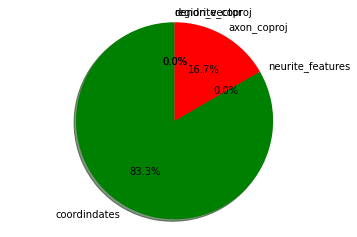

Morphology 153 1.43
	 coordindates : 57/50
	 neurite_features : 4/50
	 axon_coproj : 21/50
	 dendrite_coproj : 124/50
	 region_vector : 107/50


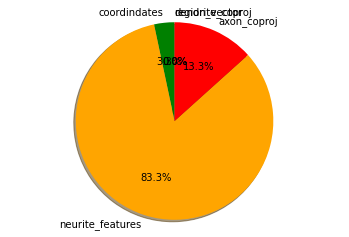

Morphology 0 1.43
	 coordindates : 1/50
	 neurite_features : 1/50
	 axon_coproj : 1/50
	 dendrite_coproj : 1/50
	 region_vector : 25/50


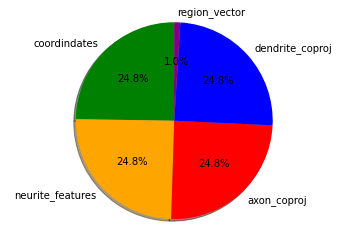

Morphology 45 1.43
	 coordindates : 103/50
	 neurite_features : 12/50
	 axon_coproj : 185/50
	 dendrite_coproj : 107/50
	 region_vector : 153/50


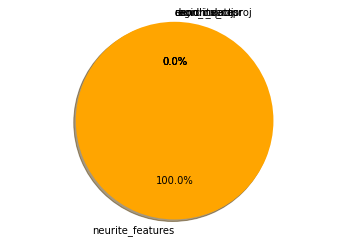

Morphology 83 1.43
	 coordindates : 122/50
	 neurite_features : 13/50
	 axon_coproj : 184/50
	 dendrite_coproj : 61/50
	 region_vector : 140/50


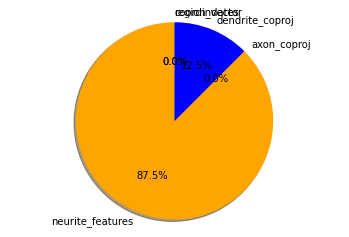

Morphology 117 1.42
	 coordindates : 84/50
	 neurite_features : 2/50
	 axon_coproj : 63/50
	 dendrite_coproj : 136/50
	 region_vector : 90/50


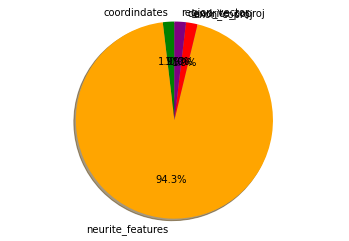

Morphology 79 1.42
	 coordindates : 145/50
	 neurite_features : 30/50
	 axon_coproj : 177/50
	 dendrite_coproj : 161/50
	 region_vector : 164/50


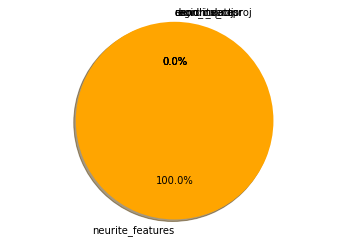

Morphology 63 1.42
	 coordindates : 105/50
	 neurite_features : 28/50
	 axon_coproj : 194/50
	 dendrite_coproj : 101/50
	 region_vector : 146/50


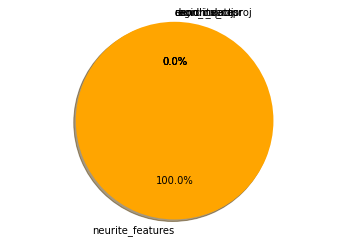

Morphology 64 1.42
	 coordindates : 110/50
	 neurite_features : 90/50
	 axon_coproj : 172/50
	 dendrite_coproj : 4/50
	 region_vector : 162/50


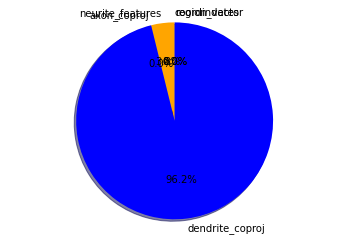

Morphology 61 1.41
	 coordindates : 118/50
	 neurite_features : 23/50
	 axon_coproj : 199/50
	 dendrite_coproj : 58/50
	 region_vector : 158/50


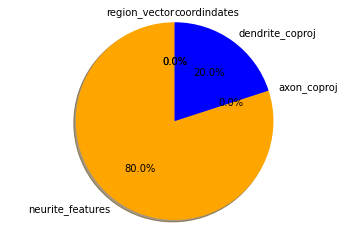

Morphology 116 1.41
	 coordindates : 93/50
	 neurite_features : 61/50
	 axon_coproj : 25/50
	 dendrite_coproj : 144/50
	 region_vector : 98/50


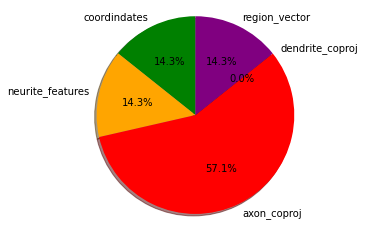

Morphology 92 1.41
	 coordindates : 117/50
	 neurite_features : 178/50
	 axon_coproj : 53/50
	 dendrite_coproj : 11/50
	 region_vector : 123/50


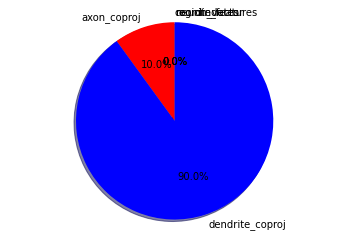

Morphology 139 1.40
	 coordindates : 51/50
	 neurite_features : 109/50
	 axon_coproj : 30/50
	 dendrite_coproj : 16/50
	 region_vector : 105/50


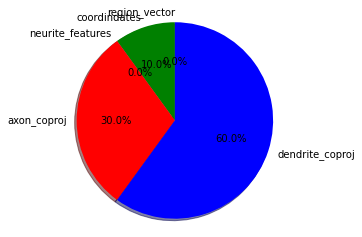

Morphology 163 1.40
	 coordindates : 106/50
	 neurite_features : 99/50
	 axon_coproj : 24/50
	 dendrite_coproj : 42/50
	 region_vector : 89/50


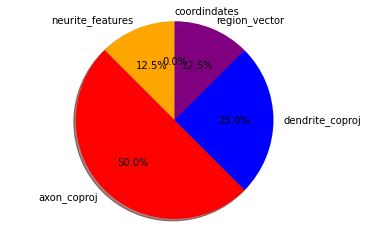

Morphology 174 1.40
	 coordindates : 78/50
	 neurite_features : 18/50
	 axon_coproj : 13/50
	 dendrite_coproj : 5/50
	 region_vector : 83/50


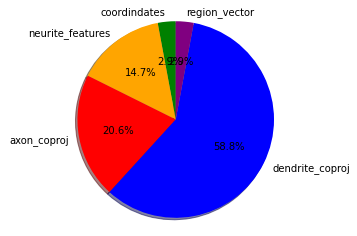

Morphology 26 1.40
	 coordindates : 63/50
	 neurite_features : 24/50
	 axon_coproj : 4/50
	 dendrite_coproj : 116/50
	 region_vector : 23/50


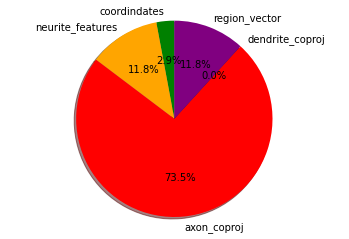

Morphology 188 1.40
	 coordindates : 35/50
	 neurite_features : 19/50
	 axon_coproj : 51/50
	 dendrite_coproj : 60/50
	 region_vector : 45/50


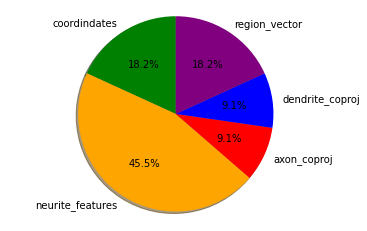

Morphology 189 1.40
	 coordindates : 16/50
	 neurite_features : 36/50
	 axon_coproj : 29/50
	 dendrite_coproj : 118/50
	 region_vector : 22/50


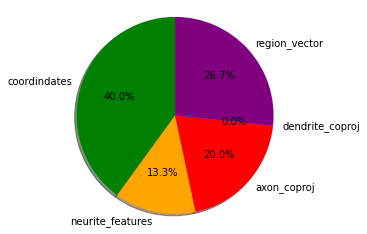

In [569]:
for el, score in result.items():
    print("Morphology", el, "{:.2f}".format(score))
    labels = []
    aspect_scores = []
    for index_name, index in INDICES.items():
        scores, points = query_index(index, [query], 200)
        position = np.where(points[0] == el)[0]
        
        if len(position) > 0:
            position = position[0]
            print("\t", index_name, f": {position + 1}/50")
            labels.append(index_name)
            aspect_scores.append(int(100 * (1 / (position + 1))))
    
    
    fig1, ax1 = plt.subplots()
    ax1.pie(aspect_scores, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=[COLORS[el] for el in labels])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

In [559]:
boosted_avg_benchmarks = {
    p: get_average_score(
        INDICES, int(p), K,
        distance_normalizer=scale_by_mean,
        similarity_booster=lambda x, index_name: x * (1 + get_boost_factor(int(p), index_name, 10)),
        similarity_normalizer=min_max_scale)
    for p in BENCHMARK_POINTS
}

In [560]:
compare_to_individual(boosted_avg_benchmarks, individual_benchmarks)

coordindates : 0.51+-0.18
neurite_features : 0.59+-0.14
axon_coproj : 0.46+-0.16
dendrite_coproj : 0.18+-0.06


In [1017]:
compare_to_individual(
    boosted_avg_benchmarks, {
        "concat": concatenated_benchmarks,
        "concat-": concatenated_minus_benchmarks,
        "avg": avg_benchmarks,
        "avg-": avg_minus_benchmarks
    })

concat : 0.48+-0.17
concat- : 0.47+-0.17
avg : 0.98+-0.03
avg- : 0.75+-0.11


## Fusion graph ranking

In [264]:
def get_position(responses, el, ascending=True):
    sorted_df = pd.DataFrame(
        responses.items(), columns=["id", "score"]).set_index("id").sort_values(
            "score", ascending=ascending)
    return sorted_df.index.get_indexer([el])[0] + 1

In [265]:
def build_fusion_graph(indices, query, k):
    query_responses = {}
    for index_name, index in indices.items():
        query_vector = index.reconstruct(query)
        scores, points = index.search(np.array([query_vector]), k)
        query_responses[index_name] = {
            el: scores[0][i] for i, el in enumerate(points[0])
        }
    
    # Create a node per unique item in response sets
    nodes = {}
    for index_response in query_responses.values():
        for key in index_response.keys():
            if key in nodes:
                nodes[key] += index_response[key]
            else:
                nodes[key] = index_response[key]

    # Compute response sets for each node being a query
    node_responses = {}
    for index_name, index in indices.items():
        node_responses[index_name] = {}
        node_list = list(nodes.keys())
        query_vectors = np.array([index.reconstruct(int(node)) for node in node_list])
        all_scores, all_points = index.search(query_vectors, k)
        node_responses[index_name] = {
            node_list[i]: {el: scores[j] for j, el in enumerate(points)}
            for i, (scores, points) in enumerate(zip(all_scores, all_points))
        }
    
    # Create edges between unique response items
    edges = {}
    for index_name in indices:
        for el in query_responses[index_name]:
            el_responses = [
                response[el] for response in node_responses.values()
            ]
            for response in el_responses:
                for target_el in response:
                    if target_el != el and target_el in nodes:
                        weight = response[target_el] / get_position(
                            query_responses[index_name], el, False)
                        if (el, target_el) not in edges:
                            edges[(el, target_el)] = weight
                        else:
                            edges[(el, target_el)] += weight
                        
    
    fusion_graph = nx.DiGraph()
    fusion_graph.add_nodes_from([
        (node, {"weight": weight})for node, weights  in nodes.items()
    ])
    fusion_graph.add_edges_from([
        (s, t, {"weight": weight}) for (s, t), weights  in edges.items()
    ])
    return fusion_graph

In [266]:
graphs = []
for i in range(data.shape[0]):
    graphs.append(build_fusion_graph(INDICES, 0, 10))